## This is a test for the third module of this analysis: station-based!

With INPUT: INCIDENT_CODE + DATE, the aims are PER STATION

-- Table output of train arrivals per period defined (hourly, 30min., etc.)

-- Delay minutes for that same defined period

-- Cancellation count

**Parameters:**
- `incident_code`: The incident number to analyze
- `incident_date`: When the incident occurred (format: 'DD-MMM-YYYY')
- `station_id`: Specific station to focus on
- `interval_minutes`: How to group the data (e.g., 15min, 30min, 60min intervals)

**Returns:**
1. **Detailed DataFrame**: Train-by-train records with delays and timestamps
2. **Summary DataFrame**: Aggregated statistics by time intervals
3. **Analysis Info**: Metadata about the incident lifecycle and parameters

In [105]:
# Import required libraries for station_view function
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime, timedelta
import sys
import matplotlib.pyplot as plt

# Ensure project root is in Python path
project_root = os.path.dirname(os.getcwd())  # Go up from demos to RDM_analysis
if project_root not in sys.path:
    sys.path.insert(0, project_root)

try:
    import importlib
    import outputs.utils
    importlib.reload(outputs.utils)
    from outputs.load_data import load_processed_data
except ImportError as e:
    print(f" Import error: {e}")
    print("Make sure you're running from the RDM_analysis directory")
except Exception as e:
    print(f" Error: {e}")


print(" Libraries imported successfully for station_view analysis")

station_view function ready!
plot_station_arrivals_violin() function ready!
plot_normal_operations_violin() function ready!
station_view function ready!
plot_station_arrivals_violin() function ready!
plot_normal_operations_violin() function ready!
 Libraries imported successfully for station_view analysis


In [106]:
from outputs.load_data import load_processed_data

all_data = load_processed_data()

✅ Loaded 10,450,237 rows from 2599 files. Skipped 0.


# here starts the OLD analysis

In [2]:
def station_view_yearly(station_id, interval_minutes=30):
    """
    Station analysis for yearly data across all incidents - simplified output.
    Analyzes all days of the week for a station and separates incident vs normal operations.
    """
    
    # Load data from all day files
    processed_base = '../processed_data'
    station_folder = os.path.join(processed_base, station_id)
    
    if not os.path.exists(station_folder):
        print(f"Station folder not found: {station_folder}")
        return None, None
    
    # Define day files to load
    day_files = ['MO.parquet', 'TU.parquet', 'WE.parquet', 'TH.parquet', 'FR.parquet', 'SA.parquet', 'SU.parquet']
    
    all_station_data = []
    
    for day_file in day_files:
        file_path = os.path.join(station_folder, day_file)
        if os.path.exists(file_path):
            try:
                day_data = pd.read_parquet(file_path, engine='fastparquet')
                day_data['day_of_week'] = day_file.replace('.parquet', '')
                all_station_data.append(day_data)
                print(f"Loaded {len(day_data)} records from {day_file}")
            except Exception as e:
                print(f"Error loading {day_file}: {e}")
        else:
            print(f"File not found: {day_file}")
    
    if not all_station_data:
        print("No data files found for this station")
        return None, None
    
    # Combine all data
    combined_data = pd.concat(all_station_data, ignore_index=True)
    print(f"Total combined records: {len(combined_data)}")
    
    # Filter for trains with planned calls
    train_mask = combined_data['PLANNED_CALLS'].notna()
    all_train_data = combined_data[train_mask].copy()
    
    # Maximum delay deduplication
    if len(all_train_data) > 0:
        all_train_data['delay_numeric'] = pd.to_numeric(all_train_data['PFPI_MINUTES'], errors='coerce').fillna(0)
        all_train_data['dedup_priority'] = all_train_data['delay_numeric'] * 1000
        
        if 'ACTUAL_CALLS' in all_train_data.columns:
            all_train_data['dedup_priority'] += all_train_data['ACTUAL_CALLS'].notna().astype(int) * 100
        
        basic_dedup_cols = ['TRAIN_SERVICE_CODE', 'PLANNED_CALLS', 'day_of_week']
        basic_available = [col for col in basic_dedup_cols if col in all_train_data.columns]
        
        if len(basic_available) >= 2:
            all_train_data = all_train_data.sort_values(['delay_numeric', 'dedup_priority'], ascending=[False, False])
            all_train_data = all_train_data.drop_duplicates(subset=basic_available, keep='first')
            all_train_data = all_train_data.drop(['delay_numeric', 'dedup_priority'], axis=1)
    
    if len(all_train_data) == 0:
        return None, None
    
    # Separate incident and normal operations
    # Assume trains with incident codes are incident-related
    incident_mask = all_train_data['INCIDENT_NUMBER'].notna()
    incident_data = all_train_data[incident_mask].copy()
    normal_data = all_train_data[~incident_mask].copy()
    
    print(f"Incident-related records: {len(incident_data)}")
    print(f"Normal operations records: {len(normal_data)}")
    
    def process_operations_data(data, operation_type):
        """Process data for either incident or normal operations"""
        if len(data) == 0:
            return pd.DataFrame()
        
        # Process times - using a reference date for time parsing
        reference_date = datetime(2024, 1, 1)  # Use a standard reference date
        
        def parse_time_simple(time_val, base_date):
            if pd.isna(time_val):
                return None
            try:
                time_str = str(int(time_val)).zfill(4)
                hour = int(time_str[:2])
                minute = int(time_str[2:])
                return base_date.replace(hour=hour, minute=minute, second=0, microsecond=0)
            except:
                return None
        
        # Parse times and apply corrected timing logic
        data['planned_dt'] = data['PLANNED_CALLS'].apply(
            lambda x: parse_time_simple(x, reference_date))
        data['original_actual_dt'] = data['ACTUAL_CALLS'].apply(
            lambda x: parse_time_simple(x, reference_date))
        data['delay_minutes'] = pd.to_numeric(data['PFPI_MINUTES'], errors='coerce').fillna(0)
        
        # Create corrected actual times
        corrected_actual_times = []
        for _, row in data.iterrows():
            planned_dt = row['planned_dt']
            original_actual_dt = row['original_actual_dt']
            delay_min = row['delay_minutes']
            
            if pd.isna(planned_dt):
                corrected_actual_times.append(None)
                continue
                
            if delay_min > 0:
                corrected_actual = planned_dt + timedelta(minutes=delay_min)
                corrected_actual_times.append(corrected_actual)
            elif delay_min == 0:
                corrected_actual_times.append(planned_dt)
            else:
                if pd.notna(original_actual_dt):
                    corrected_actual_times.append(original_actual_dt)
                else:
                    corrected_actual_times.append(planned_dt)
        
        data['effective_time'] = corrected_actual_times
        valid_data = data[data['effective_time'].notna()].copy()
        
        if len(valid_data) == 0:
            return pd.DataFrame()
        
        # Group by time intervals (using hour of day for grouping)
        valid_data['hour_of_day'] = valid_data['effective_time'].dt.hour
        valid_data['interval_group'] = (valid_data['hour_of_day'] * 60 + valid_data['effective_time'].dt.minute) // interval_minutes
        
        intervals = []
        
        for interval_group in valid_data['interval_group'].unique():
            interval_trains = valid_data[valid_data['interval_group'] == interval_group]
            
            if len(interval_trains) > 0:
                arrival_trains = interval_trains[interval_trains['EVENT_TYPE'] != 'C']
                cancellation_trains = interval_trains[interval_trains['EVENT_TYPE'] == 'C']
                
                if len(arrival_trains) > 0 or len(cancellation_trains) > 0:
                    if len(arrival_trains) > 0:
                        delay_values = arrival_trains['delay_minutes'].tolist()
                        ontime_arrivals = len([d for d in delay_values if d == 0.0])
                        delayed_arrivals = len([d for d in delay_values if d > 0.0])
                        delayed_minutes = [round(d, 1) for d in delay_values if d > 0.0]
                    else:
                        ontime_arrivals = 0
                        delayed_arrivals = 0
                        delayed_minutes = []
                    
                    total_cancellations = len(cancellation_trains)
                    
                    # Calculate time period label
                    start_minute = interval_group * interval_minutes
                    end_minute = start_minute + interval_minutes
                    start_hour = start_minute // 60
                    start_min = start_minute % 60
                    end_hour = end_minute // 60
                    end_min = end_minute % 60
                    
                    intervals.append({
                        'time_period': f"{start_hour:02d}:{start_min:02d}-{end_hour:02d}:{end_min:02d}",
                        'ontime_arrival_count': ontime_arrivals,
                        'delayed_arrival_count': delayed_arrivals,
                        'cancellation_count': total_cancellations,
                        'delay_minutes': delayed_minutes,
                        'operation_type': operation_type
                    })
        
        return pd.DataFrame(intervals)
    
    # Process both incident and normal operations
    incident_summary = process_operations_data(incident_data, 'incident')
    normal_summary = process_operations_data(normal_data, 'normal')
    
    return incident_summary, normal_summary

print("station_view_yearly function ready!")

station_view_yearly function ready!


In [3]:
# Test the updated yearly analysis function
incident_summary, normal_summary = station_view_yearly(
    station_id='12931', 
    interval_minutes=60
)

# Display the results
print("📊 YEARLY STATION ANALYSIS RESULTS:")
print("=" * 80)

if incident_summary is not None and len(incident_summary) > 0:
    print("\n🔴 INCIDENT OPERATIONS:")
    print("-" * 40)
    print(incident_summary.to_string(index=False))
    print(f"Total incident periods: {len(incident_summary)}")
    
if normal_summary is not None and len(normal_summary) > 0:
    print("\n🟢 NORMAL OPERATIONS:")
    print("-" * 40)
    print(normal_summary.to_string(index=False))
    print(f"Total normal periods: {len(normal_summary)}")

print("=" * 80)

Loaded 7549 records from MO.parquet
Loaded 7474 records from TU.parquet
Loaded 7300 records from WE.parquet
Loaded 7247 records from TH.parquet
Loaded 6941 records from FR.parquet
Loaded 4979 records from SA.parquet
Loaded 3785 records from SU.parquet
Total combined records: 45275
Incident-related records: 2887
Normal operations records: 4358
📊 YEARLY STATION ANALYSIS RESULTS:

🔴 INCIDENT OPERATIONS:
----------------------------------------
time_period  ontime_arrival_count  delayed_arrival_count  cancellation_count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [113]:
def plot_arrival_hour_distributions_violin(station_id):
    """
    Create KDE plots comparing planned vs actual arrival times for trains affected by incidents.
    
    - Uses only trains that were affected by incidents (INCIDENT_NUMBER not null)
    - Normal: Shows planned arrival times for these trains
    - Incident: Shows actual arrival times (planned + delay) for the same trains
    - Same number of trains in both distributions, showing the time shift due to incidents
    - Only includes trains that arrived (EVENT_TYPE != 'C')
    - Preserves granular minute-level data
    - Shows density on y-axis with time on x-axis
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    print(f"🚀 CREATING ARRIVAL TIME SHIFT ANALYSIS FOR INCIDENT TRAINS AT STATION {station_id}")
    print("=" * 70)

    # Filter data for the specific station from preloaded all_data
    data = all_data[all_data['STANOX'] == str(station_id)].copy()
    if len(data) == 0:
        print(f"No data found for station {station_id}")
        return None
    
    print(f"Loaded {len(data)} total records for station {station_id}")

    # Filter for trains affected by incidents
    incident_data = data[data['INCIDENT_NUMBER'].notna()].copy()
    if len(incident_data) == 0:
        print("No incident data found for this station.")
        return None
    
    # Filter for trains that arrived (exclude cancellations)
    arrived_incident_data = incident_data[incident_data['EVENT_TYPE'] != 'C'].copy()
    if len(arrived_incident_data) == 0:
        print("No arrived incident trains found.")
        return None
    
    print(f"Analyzing {len(arrived_incident_data)} incident trains that arrived")

    # Helper function to convert HHMM to minutes past midnight
    def hhmm_to_minutes(hhmm):
        if pd.isna(hhmm):
            return np.nan
        try:
            hhmm_str = str(int(hhmm)).zfill(4)
            hour = int(hhmm_str[:2])
            minute = int(hhmm_str[2:])
            return hour * 60 + minute
        except:
            return np.nan

    # Calculate delays
    arrived_incident_data['delay_minutes'] = pd.to_numeric(arrived_incident_data['PFPI_MINUTES'], errors='coerce').fillna(0)
    
    # Calculate planned arrival times in minutes
    arrived_incident_data['planned_minutes'] = arrived_incident_data['PLANNED_CALLS'].apply(hhmm_to_minutes)
    
    # Calculate actual arrival times in minutes (planned + delay)
    arrived_incident_data['actual_minutes'] = arrived_incident_data['planned_minutes'] + arrived_incident_data['delay_minutes']
    arrived_incident_data['actual_minutes'] = arrived_incident_data['actual_minutes'] % (24 * 60)  # Keep within 24 hours
    
    # Drop rows with missing times
    valid_data = arrived_incident_data.dropna(subset=['planned_minutes', 'actual_minutes']).copy()
    
    if len(valid_data) == 0:
        print("No valid time data after cleaning.")
        return None
    
    print(f"Valid data for {len(valid_data)} trains")

    # Prepare data for plotting
    plot_data = []
    
    # Normal: planned arrival times
    planned_times = valid_data['planned_minutes'].values
    plot_data.extend([{'arrival_minutes': m, 'condition': 'Planned (Normal)'} for m in planned_times])
    
    # Incident: actual arrival times
    actual_times = valid_data['actual_minutes'].values
    plot_data.extend([{'arrival_minutes': m, 'condition': 'Actual (Incident)'} for m in actual_times])
    
    plot_df = pd.DataFrame(plot_data)
    
    # Format times as HH:MM
    def minutes_to_hhmm(minutes):
        hours = int(minutes // 60)
        mins = int(minutes % 60)
        return f"{hours:02d}:{mins:02d}"

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})
    
    # Main KDE plot (top subplot)
    sns.kdeplot(data=[d['arrival_minutes'] for d in plot_data if d['condition'] == 'Planned (Normal)'], 
                ax=ax1, fill=True, alpha=0.5, color='lightgreen', 
                label=f'Planned (n={len(valid_data)})', bw_adjust=0.6)
    
    sns.kdeplot(data=[d['arrival_minutes'] for d in plot_data if d['condition'] == 'Actual (Incident)'], 
                ax=ax1, fill=True, alpha=0.5, color='lightcoral', 
                label=f'Actual (n={len(valid_data)})', bw_adjust=0.6)

    ax1.set_title(f'Arrival Time Distribution Shift Due to Incidents\nStation {station_id}',
                 fontsize=20, fontweight='bold')
    ax1.set_xlabel('')  # Remove x-label for top plot
    ax1.set_ylabel('Density', fontsize=20)
    ax1.set_xlim(-10, 24*60 + 10)  # Full 24 hours in minutes
    ax1.grid(True, alpha=0.3, axis='both')
    
    # Add hour labels on x-axis
    hour_ticks = np.arange(0, 24*60 + 1, 60)  # Every hour
    hour_labels = [f"{h//60:02d}:00" for h in hour_ticks]
    ax1.set_xticks(hour_ticks)
    ax1.set_xticklabels(hour_labels)
    
    # Add legend
    ax1.legend(loc='upper right', fontsize=15)
    
    # Delay distribution plot (bottom subplot) - density of delays
    delay_minutes = valid_data['delay_minutes'].values
    ax2.hist(delay_minutes, bins=30, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5, density=True)
    ax2.set_title('Delay Distribution Density', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Delay (minutes)', fontsize=16)
    ax2.set_ylabel('Density', fontsize=16)
    ax2.grid(True, alpha=0.3, axis='both')
    
    # Add vertical line at mean delay
    mean_delay = np.mean(delay_minutes)
    ax2.axvline(mean_delay, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_delay:.1f} min')
    ax2.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print(f"📊 STATION {station_id} INCIDENT TRAIN ARRIVAL TIME SHIFT ANALYSIS")
    print(f"{'='*80}")
    print(f"Analyzing {len(valid_data)} trains affected by incidents")
    print(f"Std planned times: {valid_data['planned_minutes'].std():.1f} minutes")
    print(f"Std actual times: {valid_data['actual_minutes'].std():.1f} minutes")
    print(f"Min planned time: {valid_data['planned_minutes'].min():.0f} minutes ({minutes_to_hhmm(valid_data['planned_minutes'].min())})")
    print(f"Max planned time: {valid_data['planned_minutes'].max():.0f} minutes ({minutes_to_hhmm(valid_data['planned_minutes'].max())})")
    print(f"Min actual time: {valid_data['actual_minutes'].min():.0f} minutes ({minutes_to_hhmm(valid_data['actual_minutes'].min())})")
    print(f"Max actual time: {valid_data['actual_minutes'].max():.0f} minutes ({minutes_to_hhmm(valid_data['actual_minutes'].max())})")
    
    # Delay statistics
    delay_stats = valid_data['delay_minutes'].describe()
    print(f"\n🚨 DELAY STATISTICS:")
    print(f"Mean delay: {delay_stats['mean']:.1f} minutes")
    print(f"Median delay: {delay_stats['50%']:.1f} minutes")
    print(f"Max delay: {delay_stats['max']:.1f} minutes")
    print(f"Std delay: {delay_stats['std']:.1f} minutes")
    print(f"Trains with delay > 0: {len(valid_data[valid_data['delay_minutes'] > 0])} ({100*len(valid_data[valid_data['delay_minutes'] > 0])/len(valid_data):.1f}%)")
    print(f"Trains on time: {len(valid_data[valid_data['delay_minutes'] == 0])} ({100*len(valid_data[valid_data['delay_minutes'] == 0])/len(valid_data):.1f}%)")
    
    plt.show()
    return plot_df

print("plot_arrival_hour_distributions_violin function ready!")


plot_arrival_hour_distributions_violin function ready!


🚀 CREATING ARRIVAL TIME SHIFT ANALYSIS FOR INCIDENT TRAINS AT STATION 73000
Loaded 84250 total records for station 73000
Analyzing 13761 incident trains that arrived
Valid data for 13761 trains
Loaded 84250 total records for station 73000
Analyzing 13761 incident trains that arrived
Valid data for 13761 trains

📊 STATION 73000 INCIDENT TRAIN ARRIVAL TIME SHIFT ANALYSIS
Analyzing 13761 trains affected by incidents
Std planned times: 316.3 minutes
Std actual times: 317.8 minutes
Min planned time: 2 minutes (00:02)
Max planned time: 1439 minutes (23:59)
Min actual time: 0 minutes (00:00)
Max actual time: 1439 minutes (23:59)

🚨 DELAY STATISTICS:
Mean delay: 6.9 minutes
Median delay: 4.0 minutes
Max delay: 83.0 minutes
Std delay: 7.4 minutes
Trains with delay > 0: 13759 (100.0%)
Trains on time: 2 (0.0%)

📊 STATION 73000 INCIDENT TRAIN ARRIVAL TIME SHIFT ANALYSIS
Analyzing 13761 trains affected by incidents
Std planned times: 316.3 minutes
Std actual times: 317.8 minutes
Min planned time: 2

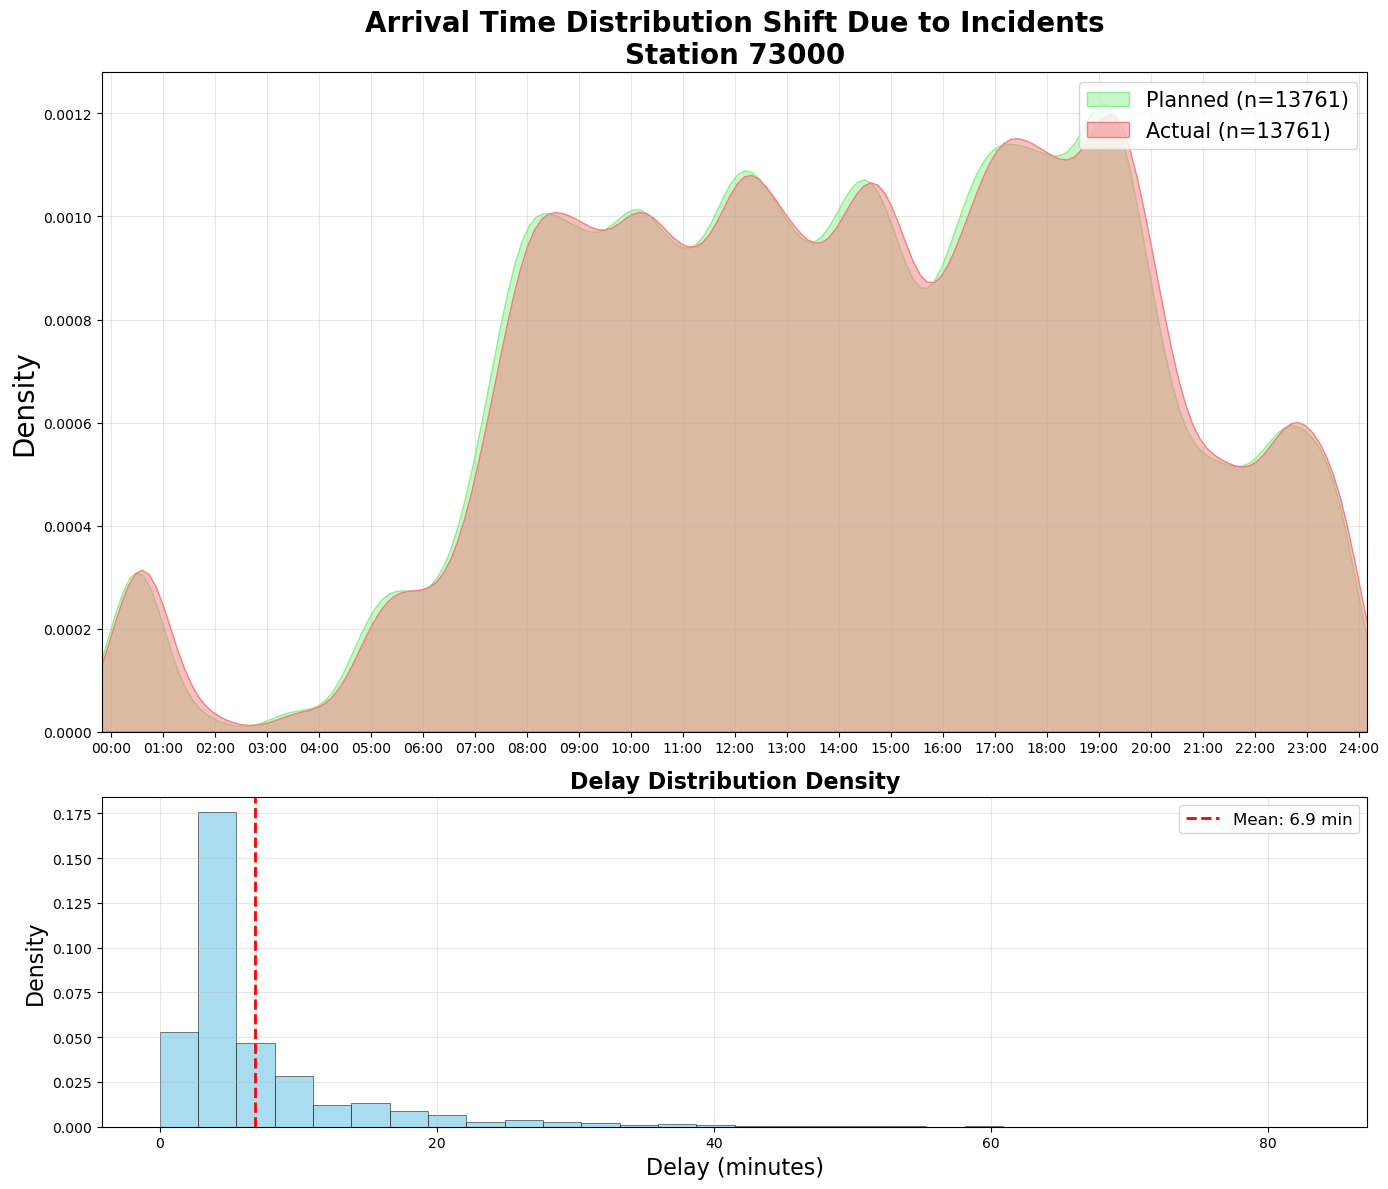

In [114]:
violin_results = plot_arrival_hour_distributions_violin(station_id='73000')

🚀 CREATING ARRIVAL TIME SHIFT ANALYSIS FOR INCIDENT TRAINS AT STATION 32000
Loaded 217738 total records for station 32000
Analyzing 38112 incident trains that arrived
Valid data for 38112 trains
Loaded 217738 total records for station 32000
Analyzing 38112 incident trains that arrived
Valid data for 38112 trains

📊 STATION 32000 INCIDENT TRAIN ARRIVAL TIME SHIFT ANALYSIS
Analyzing 38112 trains affected by incidents
Std planned times: 313.9 minutes
Std actual times: 316.3 minutes
Min planned time: 1 minutes (00:01)
Max planned time: 1439 minutes (23:59)
Min actual time: 0 minutes (00:00)
Max actual time: 1440 minutes (23:59)

🚨 DELAY STATISTICS:
Mean delay: 6.5 minutes
Median delay: 3.0 minutes
Max delay: 279.0 minutes
Std delay: 9.3 minutes
Trains with delay > 0: 38097 (100.0%)
Trains on time: 15 (0.0%)

📊 STATION 32000 INCIDENT TRAIN ARRIVAL TIME SHIFT ANALYSIS
Analyzing 38112 trains affected by incidents
Std planned times: 313.9 minutes
Std actual times: 316.3 minutes
Min planned tim

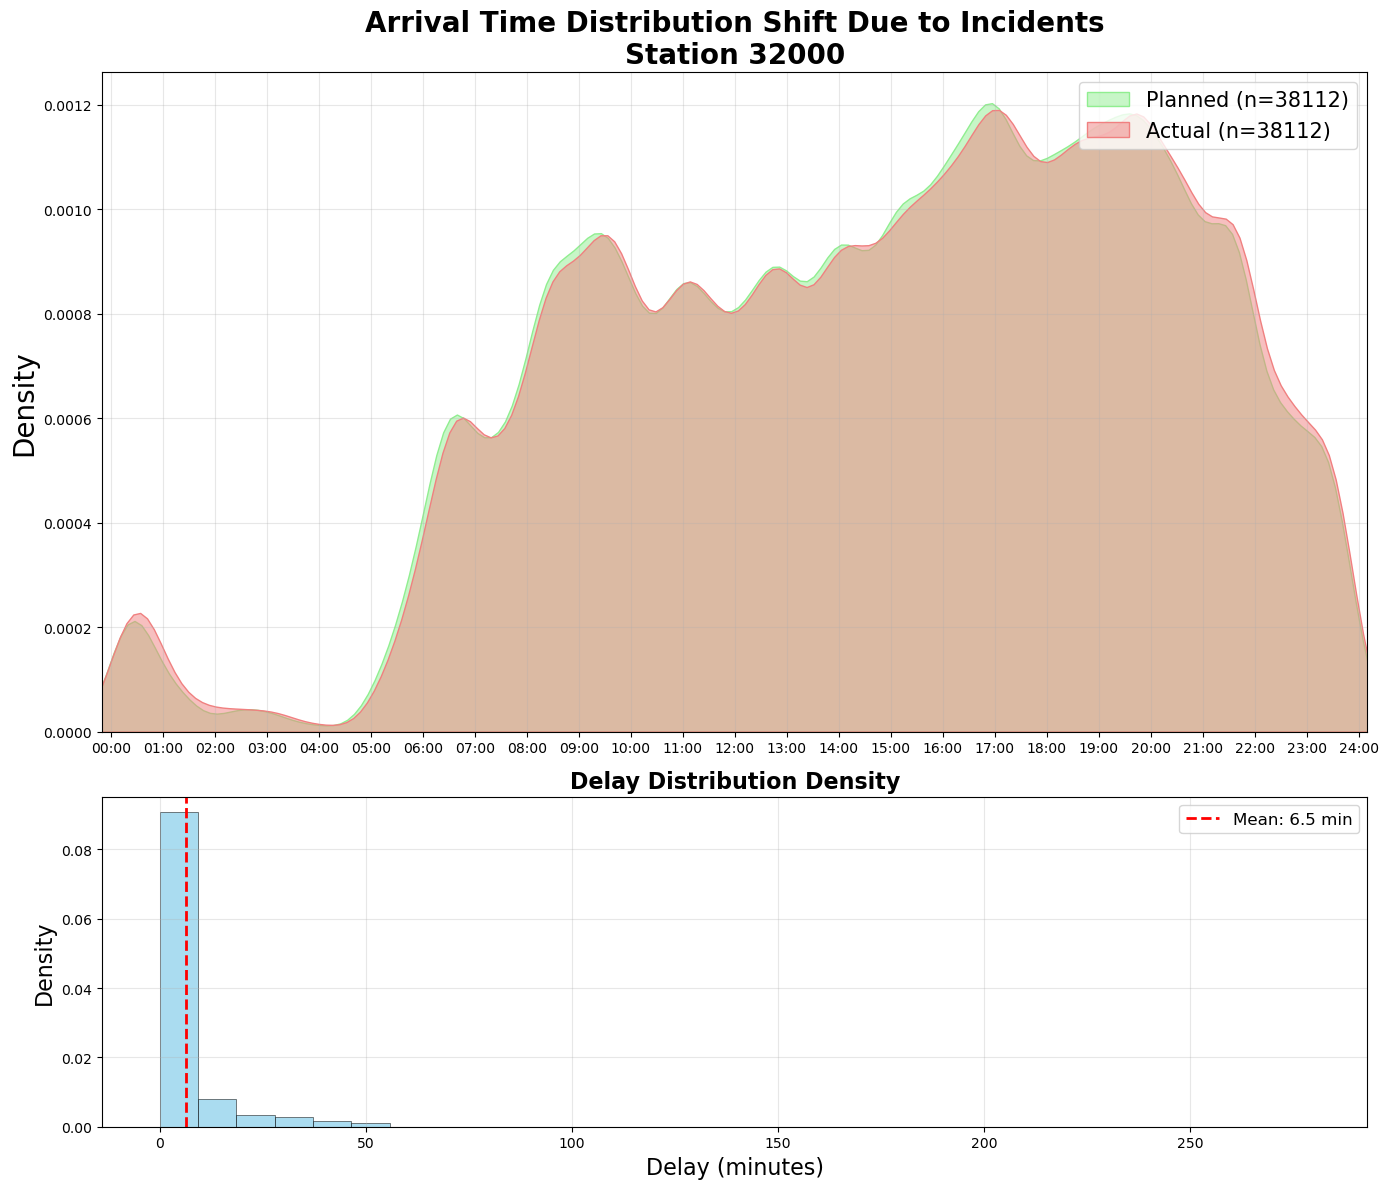

In [115]:
violin_results = plot_arrival_hour_distributions_violin(station_id='32000')

In [40]:
def plot_flow_rate_vs_delays_kde(station_id, time_window_minutes=60, num_platforms=12, figsize=(14, 10), bw_adjust=0.8, specific_hour=None):
    """
    Create 2D KDE plots showing the relationship between flow rate and individual train delays.
    
    Disaggregates yearly data into hourly bins. For each hour, calculates flow rate and plots each individual train's delay
    against that hour's flow rate. Shows scatter points with overlaid KDE density for incident operations.
    
    If specific_hour is provided (0-23), also creates additional plots showing the same analysis for only that hour.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    plt.style.use('default')
    sns.set_palette("husl")

    print(f"🚀 CREATING 2D KDE (flow vs delay) FOR STATION {station_id}")
    print("=" * 60)

    # Filter data for the specific station from preloaded all_data
    data = all_data[all_data['STANOX'] == str(station_id)].copy()
    if len(data) == 0:
        print(f"No data found for station {station_id}")
        return None
    
    print(f"Loaded {len(data)} total records for station {station_id}")

    # Filter for incident operations only
    incident_data = data[data['INCIDENT_NUMBER'].notna()].copy()
    if len(incident_data) == 0:
        print("No incident data found for this station.")
        return None

    # Filter for trains that arrived (exclude cancellations)
    arrived_incident_data = incident_data[incident_data['EVENT_TYPE'] != 'C'].copy()
    if len(arrived_incident_data) == 0:
        print("No arrived incident trains found.")
        return None

    # Calculate delays
    arrived_incident_data['delay_minutes'] = pd.to_numeric(arrived_incident_data['PFPI_MINUTES'], errors='coerce').fillna(0)

    # Helper function to convert HHMM to minutes past midnight
    def time_to_minutes(t):
        try:
            s = str(int(t)).zfill(4)
            return int(s[:2]) * 60 + int(s[2:])
        except Exception:
            return np.nan

    # Calculate actual arrival time in minutes
    arrived_incident_data['planned_minutes'] = arrived_incident_data['PLANNED_CALLS'].apply(time_to_minutes)
    arrived_incident_data['actual_minutes'] = arrived_incident_data['planned_minutes'] + arrived_incident_data['delay_minutes']
    arrived_incident_data['actual_minutes'] = arrived_incident_data['actual_minutes'] % (24 * 60)

    # Create datetime for grouping
    # Map day of week to reference dates for grouping
    day_map = {'MO': '2024-01-01', 'TU': '2024-01-02', 'WE': '2024-01-03', 
               'TH': '2024-01-04', 'FR': '2024-01-05', 'SA': '2024-01-06', 'SU': '2024-01-07'}
    arrived_incident_data['date_str'] = arrived_incident_data['DAY'].map(day_map)
    arrived_incident_data['date'] = pd.to_datetime(arrived_incident_data['date_str'], errors='coerce')
    arrived_incident_data['hour'] = (arrived_incident_data['actual_minutes'] / 60).astype(int)

    # Drop rows with invalid dates
    valid_data = arrived_incident_data.dropna(subset=['date', 'actual_minutes']).copy()

    if len(valid_data) == 0:
        print("No valid datetime data for hourly binning.")
        return None

    # Group by date and hour
    hourly_groups = valid_data.groupby(['date', 'hour'])

    # Collect all individual data points
    all_points = []
    for (date, hour), group in hourly_groups:
        flow_rate = len(group) / num_platforms  # trains per hour per platform
        for _, train in group.iterrows():
            all_points.append({'flow_rate': flow_rate, 'delay_minutes': train['delay_minutes'], 'hour': hour})

    if not all_points:
        print("No data points to plot.")
        return None

    points_df = pd.DataFrame(all_points)
    print(f"Collected {len(points_df)} individual data points from incident operations")

    # Create figure with subplots for marginal distributions
    fig = plt.figure(figsize=figsize)
    
    # Create main 2D KDE plot
    gs = fig.add_gridspec(4, 4, hspace=0.1, wspace=0.1)
    main_ax = fig.add_subplot(gs[1:, :-1])
    
    # Marginal plots
    x_hist = fig.add_subplot(gs[0, :-1], sharex=main_ax)
    y_hist = fig.add_subplot(gs[1:, -1], sharey=main_ax)
    
    # Hide tick labels on marginal plots
    x_hist.tick_params(axis="x", labelbottom=False)
    y_hist.tick_params(axis="y", labelleft=False)

    # Scatter plot of individual points
    main_ax.scatter(points_df['flow_rate'], points_df['delay_minutes'], 
                   alpha=0.6, color='lightgrey', s=30, edgecolors='lightgrey', linewidth=0.5)
    
    # Add trend line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(points_df['flow_rate'], points_df['delay_minutes'])
    x_range = np.linspace(points_df['flow_rate'].min(), points_df['flow_rate'].max(), 100)
    y_trend = slope * x_range + intercept
    main_ax.plot(x_range, y_trend, 'r-', linewidth=2, label=f'Trend: r={r_value:.3f}')
    
    # Overlay 2D KDE
    sns.kdeplot(data=points_df, x='flow_rate', y='delay_minutes', ax=main_ax, cmap='viridis',
               fill=True, alpha=0.8, levels=10, bw_adjust=bw_adjust)
    
    # Marginal KDE plots
    sns.kdeplot(data=points_df, x='flow_rate', ax=x_hist, fill=True, alpha=0.7, color='skyblue')
    sns.kdeplot(data=points_df, y='delay_minutes', ax=y_hist, fill=True, alpha=0.7, color='salmon')
    
    # Set labels
    main_ax.set_xlabel('Flow Rate (trains/hour/platform)', fontsize=20)
    main_ax.set_ylabel('Delay (minutes)', fontsize=20)
    main_ax.set_title(f'2D KDE: Flow Rate vs Delay\nStation {station_id} - Incident Operations', fontsize=16)
    main_ax.grid(True, alpha=0.3)
    main_ax.legend(loc='upper right')
    
    plt.tight_layout()

    # Print summary statistics
    print(f"\n{'='*80}")
    print(f"🚆 STATION {station_id} FLOW RATE VS DELAY PER TRAIN KDE ANALYSIS")
    print(f"{'='*80}")
    print(f"Analyzed {len(points_df)} individual train delays from incident operations")
    print(f"Mean flow rate: {points_df['flow_rate'].mean():.2f} trains/hour/platform")
    print(f"Mean delay per train: {points_df['delay_minutes'].mean():.1f} minutes")
    print(f"Correlation (flow vs delay per train): {points_df[['flow_rate', 'delay_minutes']].corr().iloc[0,1]:.3f}")
    print(f"Max flow rate: {points_df['flow_rate'].max():.2f}")
    print(f"Max delay per train: {points_df['delay_minutes'].max():.1f}")

    plt.show()
    
    # Create 3D KDE plot
    print("\n📊 Creating 3D KDE visualization...")
    from mpl_toolkits.mplot3d import Axes3D
    
    fig_3d = plt.figure(figsize=(12, 8))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    
    # Create KDE data for 3D plotting
    
    # Get KDE values
    xmin, xmax = points_df['flow_rate'].min(), points_df['flow_rate'].max()
    ymin, ymax = points_df['delay_minutes'].min(), points_df['delay_minutes'].max()
    
    # Create grid
    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([points_df['flow_rate'], points_df['delay_minutes']])
    
    # Fit KDE
    kernel = stats.gaussian_kde(values, bw_method=bw_adjust)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # Plot 3D surface
    surf = ax_3d.plot_surface(xx, yy, f, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
    
    ax_3d.set_xlabel('Flow Rate (trains/hour/platform)', fontsize=12)
    ax_3d.set_ylabel('Delay (minutes)', fontsize=12)
    ax_3d.set_zlabel('Density', fontsize=12)
    ax_3d.set_title(f'3D KDE: Flow Rate vs Delay Density\nStation {station_id} - Incident Operations', fontsize=14)
    
    # Add colorbar
    fig_3d.colorbar(surf, ax=ax_3d, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()
    
    # If specific_hour is provided, create additional plots for that hour
    if specific_hour is not None:
        specific_points = [p for p in all_points if p['hour'] == specific_hour]
        if specific_points:
            specific_df = pd.DataFrame(specific_points)
            print(f"\nCollected {len(specific_df)} data points for hour {specific_hour}")
            
            # Create 2D KDE plot for specific hour
            fig_specific = plt.figure(figsize=figsize)
            gs_specific = fig_specific.add_gridspec(4, 4, hspace=0.1, wspace=0.1)
            main_ax_specific = fig_specific.add_subplot(gs_specific[1:, :-1])
            x_hist_specific = fig_specific.add_subplot(gs_specific[0, :-1], sharex=main_ax_specific)
            y_hist_specific = fig_specific.add_subplot(gs_specific[1:, -1], sharey=main_ax_specific)
            
            x_hist_specific.tick_params(axis="x", labelbottom=False)
            y_hist_specific.tick_params(axis="y", labelleft=False)
            
            main_ax_specific.scatter(specific_df['flow_rate'], specific_df['delay_minutes'], 
                                   alpha=0.6, color='lightgrey', s=30, edgecolors='lightgrey', linewidth=0.5)
            
            # Add trend line for specific hour
            slope_s, intercept_s, r_value_s, p_value_s, std_err_s = stats.linregress(specific_df['flow_rate'], specific_df['delay_minutes'])
            x_range_s = np.linspace(specific_df['flow_rate'].min(), specific_df['flow_rate'].max(), 100)
            y_trend_s = slope_s * x_range_s + intercept_s
            main_ax_specific.plot(x_range_s, y_trend_s, 'r-', linewidth=2, label=f'Trend: r={r_value_s:.3f}')
            
            sns.kdeplot(data=specific_df, x='flow_rate', y='delay_minutes', ax=main_ax_specific, cmap='viridis',
                       fill=True, alpha=0.8, levels=10, bw_adjust=bw_adjust)
            sns.kdeplot(data=specific_df, x='flow_rate', ax=x_hist_specific, fill=True, alpha=0.7, color='skyblue')
            sns.kdeplot(data=specific_df, y='delay_minutes', ax=y_hist_specific, fill=True, alpha=0.7, color='salmon')
            
            main_ax_specific.set_xlabel('Flow Rate (trains/hour/platform)', fontsize=20)
            main_ax_specific.set_ylabel('Delay (minutes)', fontsize=20)
            main_ax_specific.set_title(f'2D KDE: Flow Rate vs Delay (Hour {specific_hour})\nStation {station_id} - Incident Operations', fontsize=16)
            main_ax_specific.grid(True, alpha=0.3)
            main_ax_specific.legend(loc='upper right')
            
            plt.tight_layout()
            plt.show()
            
            # Print summary for specific hour
            print(f"\n{'='*80}")
            print(f"🚆 STATION {station_id} FLOW RATE VS DELAY PER TRAIN KDE ANALYSIS (HOUR {specific_hour})")
            print(f"{'='*80}")
            print(f"Analyzed {len(specific_df)} individual train delays from incident operations")
            print(f"Mean flow rate: {specific_df['flow_rate'].mean():.2f} trains/hour/platform")
            print(f"Mean delay per train: {specific_df['delay_minutes'].mean():.1f} minutes")
            print(f"Correlation (flow vs delay per train): {specific_df[['flow_rate', 'delay_minutes']].corr().iloc[0,1]:.3f}")
            print(f"Max flow rate: {specific_df['flow_rate'].max():.2f}")
            print(f"Max delay per train: {specific_df['delay_minutes'].max():.1f}")
            
            # 3D KDE for specific hour
            print("\n📊 Creating 3D KDE visualization for specific hour...")
            fig_3d_specific = plt.figure(figsize=(12, 8))
            ax_3d_specific = fig_3d_specific.add_subplot(111, projection='3d')
            
            xmin_s, xmax_s = specific_df['flow_rate'].min(), specific_df['flow_rate'].max()
            ymin_s, ymax_s = specific_df['delay_minutes'].min(), specific_df['delay_minutes'].max()
            
            xx_s, yy_s = np.mgrid[xmin_s:xmax_s:50j, ymin_s:ymax_s:50j]
            positions_s = np.vstack([xx_s.ravel(), yy_s.ravel()])
            values_s = np.vstack([specific_df['flow_rate'], specific_df['delay_minutes']])
            
            kernel_s = stats.gaussian_kde(values_s, bw_method=bw_adjust)
            f_s = np.reshape(kernel_s(positions_s).T, xx_s.shape)
            
            surf_s = ax_3d_specific.plot_surface(xx_s, yy_s, f_s, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
            
            ax_3d_specific.set_xlabel('Flow Rate (trains/hour/platform)', fontsize=12)
            ax_3d_specific.set_ylabel('Delay (minutes)', fontsize=12)
            ax_3d_specific.set_zlabel('Density', fontsize=12)
            ax_3d_specific.set_title(f'3D KDE: Flow Rate vs Delay Density (Hour {specific_hour})\nStation {station_id} - Incident Operations', fontsize=14)
            
            fig_3d_specific.colorbar(surf_s, ax=ax_3d_specific, shrink=0.5, aspect=5)
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"No data found for hour {specific_hour}")
    
    return points_df

print("plot_flow_rate_vs_delays_kde function ready!")

plot_flow_rate_vs_delays_kde function ready!


Testing 2D KDE flow rate vs delays function for hour 8...
🚀 CREATING 2D KDE (flow vs delay) FOR STATION 73000
Loaded 84250 total records for station 73000
Collected 13761 individual data points from incident operations
Collected 13761 individual data points from incident operations


C:\Users\39342\AppData\Local\Temp\ipykernel_22500\2988633759.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



🚆 STATION 73000 FLOW RATE VS DELAY PER TRAIN KDE ANALYSIS
Analyzed 13761 individual train delays from incident operations
Mean flow rate: 10.31 trains/hour/platform
Mean delay per train: 6.9 minutes
Correlation (flow vs delay per train): -0.049
Max flow rate: 18.82
Max delay per train: 83.0


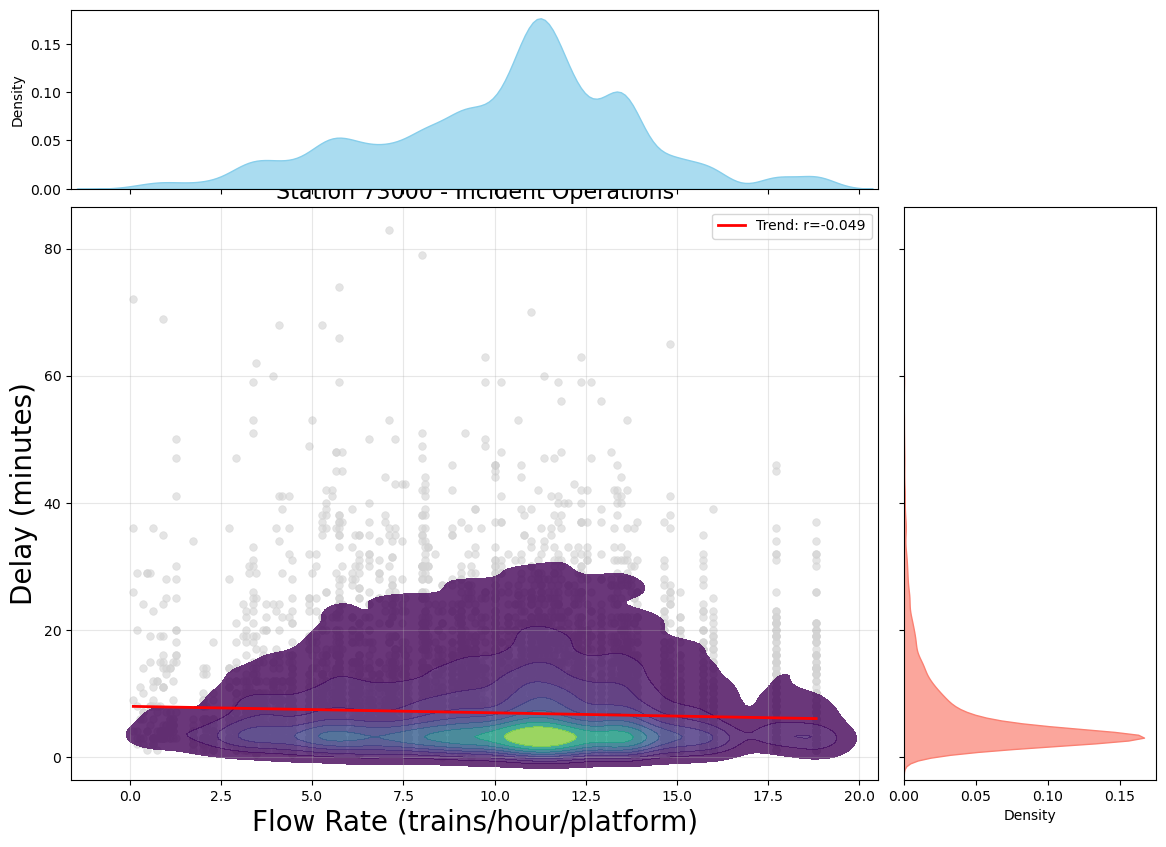


📊 Creating 3D KDE visualization...


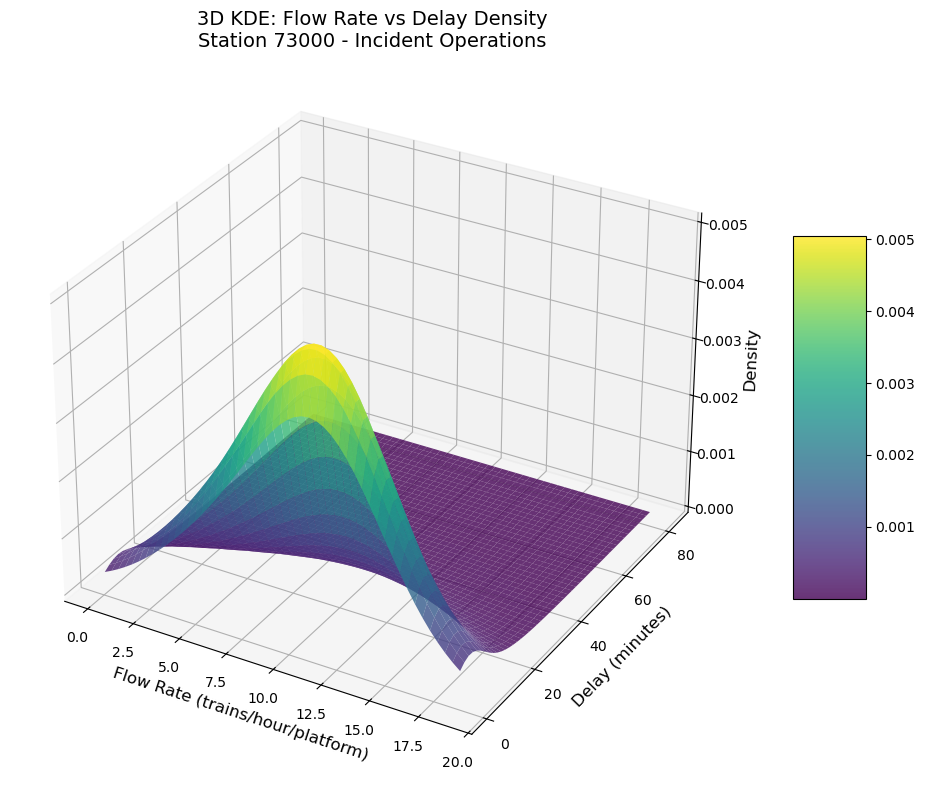


Collected 841 data points for hour 8


C:\Users\39342\AppData\Local\Temp\ipykernel_22500\2988633759.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


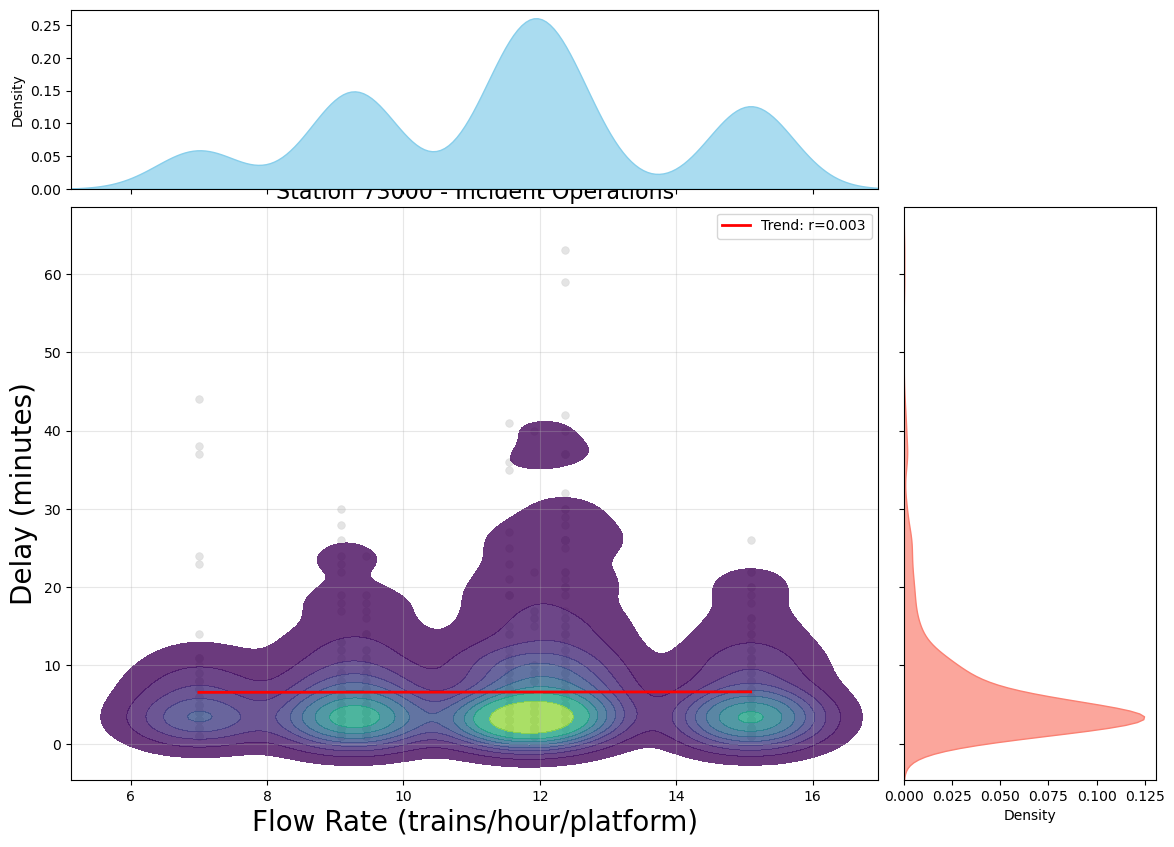


🚆 STATION 73000 FLOW RATE VS DELAY PER TRAIN KDE ANALYSIS (HOUR 8)
Analyzed 841 individual train delays from incident operations
Mean flow rate: 11.47 trains/hour/platform
Mean delay per train: 6.6 minutes
Correlation (flow vs delay per train): 0.003
Max flow rate: 15.09
Max delay per train: 63.0

📊 Creating 3D KDE visualization for specific hour...


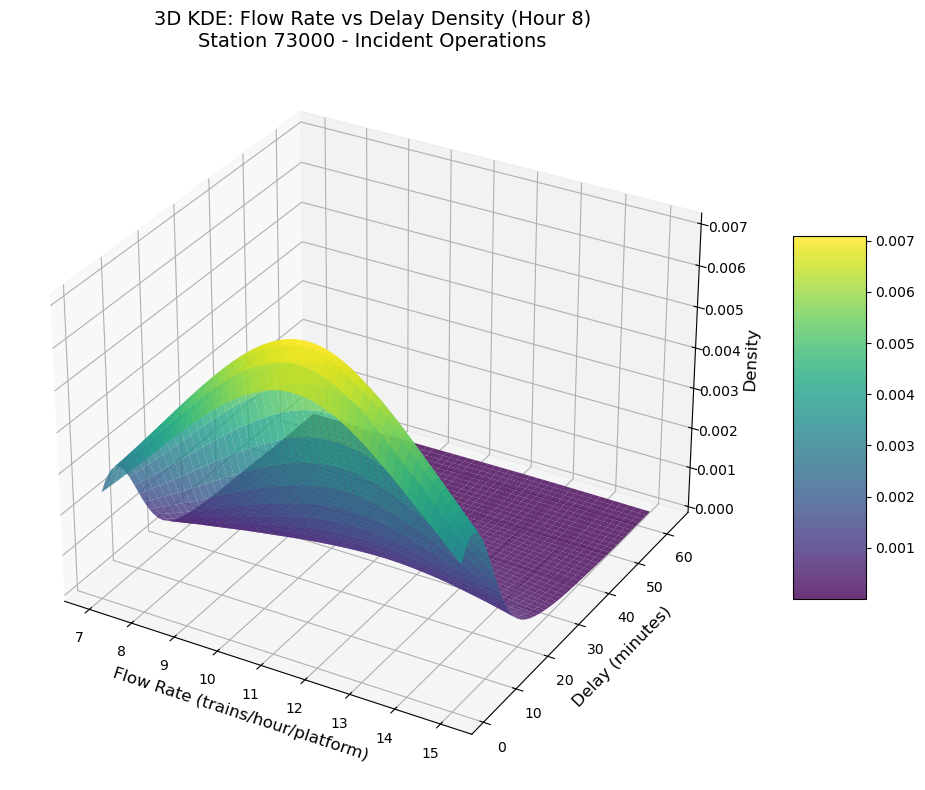

In [41]:
# Test the 2D KDE function with specific hour
print("Testing 2D KDE flow rate vs delays function for hour 8...")
ultra_smooth_results = plot_flow_rate_vs_delays_kde(
    station_id='73000',
    time_window_minutes=60,
    num_platforms=11,
    figsize=(14, 10),
    specific_hour=8
)
plt.show()

The local KDE density is an estimate of the joint probability density at a specific point in the 2D space (flow, delay). High values mean many trains lie close to that point in the plotted variable space.

# here starts the NEW analysis

### Flow Calculation - Temporal Resolution Approach

**New Temporal Flow Calculation:**

The `plot_variable_relationships` function now uses **actual timestamps** to preserve temporal resolution, avoiding over-averaging:

**Key Changes:**
1. **No Pre-Averaging**: Instead of dividing by 52 weeks, we keep individual hourly observations
2. **Time Series Analysis**: Uses `pd.Grouper(freq='h')` to create hourly time series
3. **Richer Data**: Each data point represents an actual hour with real flow and delay values

**Process:**
1. **Create DateTime Timestamps**: 
   - Convert day codes (MO, TU, etc.) and time values into proper datetime objects
   - Maps each weekday to its first occurrence in 2024 for temporal ordering

2. **Time Series Grouping**:
   ```python
   # Count trains per hour using pd.Grouper
   hourly_flow = data.groupby(pd.Grouper(freq='H')).size()
   hourly_delay = data.groupby(pd.Grouper(freq='H'))['delay_minutes'].mean()
   ```

3. **Separate by Day Type**:
   - Weekdays: Monday-Friday (derived from datetime.dayofweek < 5)
   - Weekends: Saturday-Sunday (derived from datetime.dayofweek >= 5)

4. **Flow Statistics by Hour**:
   - Mean, Std, Median, Q25, Q75, Min, Max, Count
   - Calculated for each hour of day (00:00-23:00)
   - Shows variability and distribution of flow patterns

**Example:**
- Monday 8am, Week 1: 12 trains → Flow = 12 trains/hour
- Monday 8am, Week 2: 8 trains → Flow = 8 trains/hour  
- Monday 8am, Week 3: 15 trains → Flow = 15 trains/hour
- **Result**: 3 separate observations, NOT averaged to 11.67

**Output:**
- **Scatter plots**: Flow vs Delay for weekdays and weekends
- **Statistics tables**: Flow statistics by hour of day (mean, std, quantiles)
- **Each point**: Represents an actual hour with real observed flow

**Benefits:**
- ✓ Preserves temporal resolution
- ✓ Shows natural variability in flow
- ✓ Enables time series analysis
- ✓ More realistic correlation estimates
- ✓ Identifies hourly patterns and outliers

**Units:**
- **Flow**: trains/hour (actual count per specific hour, not averaged)

In [133]:
def plot_variable_relationships(station_id, time_window_minutes=60, num_platforms=12, figsize=(14, 10), max_delay_percentile=98):
    """
    Create scatter plots showing relationship between flow and delays - ONE POINT PER HOUR.
    Separates analysis into WEEKDAYS (Mon-Fri) and WEEKENDS (Sat-Sun).

    Flow vs Mean Delay (minutes) - Y: flow, X: mean delay

    IMPORTANT: 
    - Flow is calculated using ALL trains (incident and non-incident) per hour.
    - Mean delay is calculated ONLY from delayed trains (delay > 0) per hour.
    - Each data point = ONE SPECIFIC HOUR on one specific day across the full year.
    
    Expected data points: 
    - Weekdays: ~260 days × 24 hours = ~6,240 points (minus hours with no delays)
    - Weekends: ~104 days × 24 hours = ~2,496 points (minus hours with no delays)
    
    max_delay_percentile: Trim delays above this percentile to reduce outlier influence (default 98%).
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    plt.style.use('default')
    sns.set_palette("husl")

    print(f"🚀 CREATING TEMPORAL FLOW ANALYSIS FOR STATION {station_id}")
    print("=" * 70)

    # Filter data for the specific station from preloaded all_data
    data = all_data[all_data['STANOX'] == str(station_id)].copy()
    if len(data) == 0:
        print(f"No data found for station {station_id}")
        return None
    
    print(f"Loaded {len(data)} total records for station {station_id}")

    # Filter for ALL trains that arrived (exclude cancellations) - not just incident trains
    all_arrived_data = data[data['EVENT_TYPE'] != 'C'].copy()
    if len(all_arrived_data) == 0:
        print("No arrived trains found.")
        return None
    
    print(f"Using {len(all_arrived_data)} arrived trains (both incident and non-incident) for flow calculation")

    # Calculate delays for all trains
    all_arrived_data['delay_minutes'] = pd.to_numeric(all_arrived_data['PFPI_MINUTES'], errors='coerce').fillna(0)
    
    # Mark which trains have delays > 0 (for delay statistics)
    all_arrived_data['has_delay'] = all_arrived_data['delay_minutes'] > 0

    # Create proper datetime timestamps using EVENT_DATETIME column
    print("Creating datetime timestamps from EVENT_DATETIME...")
    
    def parse_event_datetime(event_dt_str):
        """Parse EVENT_DATETIME string to extract date"""
        if pd.isna(event_dt_str):
            return None
        try:
            # EVENT_DATETIME format: 'DD-MMM-YYYY HH:MM'
            dt = pd.to_datetime(event_dt_str, format='%d-%b-%Y %H:%M', errors='coerce')
            return dt.date() if pd.notna(dt) else None
        except:
            return None
    
    # Extract dates from EVENT_DATETIME for incident trains
    all_arrived_data['event_date'] = all_arrived_data['EVENT_DATETIME'].apply(parse_event_datetime)
    
    # Get mapping of day code to dates from incident trains
    day_to_weekday = {'MO': 0, 'TU': 1, 'WE': 2, 'TH': 3, 'FR': 4, 'SA': 5, 'SU': 6}
    
    # Build a mapping of DAY code to all observed dates
    day_date_mapping = {}
    for day_code in day_to_weekday.keys():
        day_data = all_arrived_data[all_arrived_data['DAY'] == day_code]
        observed_dates = day_data['event_date'].dropna().unique()
        if len(observed_dates) > 0:
            day_date_mapping[day_code] = sorted(observed_dates)
    
    print(f"Found date mappings for {len(day_date_mapping)} day codes")
    for day_code, dates in day_date_mapping.items():
        if len(dates) > 0:
            print(f"  {day_code}: {len(dates)} unique dates from {dates[0]} to {dates[-1]}")
    
    # Create row index for better distribution
    all_arrived_data['row_idx'] = range(len(all_arrived_data))
    
    def create_datetime_with_event_dates(row):
        """Create datetime using EVENT_DATETIME dates or inferred dates"""
        try:
            day_code = row['DAY']
            time_val = row['ACTUAL_CALLS'] if pd.notna(row['ACTUAL_CALLS']) else row['PLANNED_CALLS']
            
            if pd.isna(time_val) or day_code not in day_to_weekday:
                return None
            
            # Parse time
            time_str = str(int(time_val)).zfill(4)
            hour = int(time_str[:2])
            minute = int(time_str[2:])
            
            # Get date - prioritize EVENT_DATETIME if available
            if pd.notna(row['event_date']):
                date_obj = row['event_date']
            else:
                # For non-incident trains, distribute across ALL observed dates for this day
                # Use row index combined with train ID for better distribution
                if day_code in day_date_mapping and len(day_date_mapping[day_code]) > 0:
                    # Use row index to get different dates for same train on different occurrences
                    date_idx = (hash(str(row['TRAIN_SERVICE_CODE'])) + row['row_idx']) % len(day_date_mapping[day_code])
                    date_obj = day_date_mapping[day_code][date_idx]
                else:
                    return None
            
            # Create datetime with time
            dt = pd.Timestamp(year=date_obj.year, month=date_obj.month, 
                            day=date_obj.day, hour=hour, minute=minute)
            return dt
        except:
            return None
    
    all_arrived_data['datetime'] = all_arrived_data.apply(create_datetime_with_event_dates, axis=1)
    
    # Drop rows with invalid datetimes
    valid_data = all_arrived_data.dropna(subset=['datetime']).copy()
    
    if len(valid_data) == 0:
        print("No valid datetime data.")
        return None
    
    print(f"Created {len(valid_data)} valid timestamps")
    
    # Set datetime as index for time-series operations
    valid_data = valid_data.set_index('datetime').sort_index()
    
    # Add day type
    valid_data['day_type'] = valid_data.index.dayofweek.map(
        lambda x: 'weekday' if x < 5 else 'weekend'
    )
    valid_data['hour_of_day'] = valid_data.index.hour
    valid_data['weekday_name'] = valid_data.index.day_name()

    # Process separately for weekdays and weekends
    def process_day_type(data_subset, day_type_name):
        """Process data for either weekdays or weekends - one data point per hour"""
        if len(data_subset) == 0:
            return pd.DataFrame(), pd.DataFrame()
        
        # Count UNIQUE trains per hour using TRAIN_SERVICE_CODE (ALL trains for flow)
        hourly_flow = data_subset.groupby(pd.Grouper(freq='h'))['TRAIN_SERVICE_CODE'].nunique()
        
        # Filter only delayed trains (delay > 0) for delay statistics
        delayed_trains = data_subset[data_subset['has_delay']].copy()
        
        # Calculate mean delay per hour ONLY from trains with delays > 0
        if len(delayed_trains) > 0:
            hourly_mean_delay = delayed_trains.groupby(pd.Grouper(freq='h'))['delay_minutes'].mean()
        else:
            # No delayed trains - create empty series
            hourly_mean_delay = pd.Series(dtype=float)
        
        # Combine flow and delay - one row per hour
        hourly_stats = pd.DataFrame({
            'flow': hourly_flow,
            'mean_delay': hourly_mean_delay
        })
        
        # Keep all hours with flow (trains operated)
        # For hours with no delays, mean_delay will be NaN - fill with 0 for visualization
        hourly_stats = hourly_stats[hourly_stats['flow'].notna()].copy()
        hourly_stats['mean_delay'] = hourly_stats['mean_delay'].fillna(0)
        
        if len(hourly_stats) == 0:
            return pd.DataFrame(), pd.DataFrame()
        
        # Add hour of day for statistics
        hourly_stats['hour_of_day'] = hourly_stats.index.hour
        hourly_stats['day_type'] = day_type_name
        hourly_stats['datetime'] = hourly_stats.index
        
        # Trim outliers using mean delay
        if max_delay_percentile < 100 and len(hourly_stats) > 0:
            delay_threshold = hourly_stats['mean_delay'].quantile(max_delay_percentile / 100)
            hourly_stats = hourly_stats[hourly_stats['mean_delay'] <= delay_threshold]
        
        # Calculate summary statistics by hour of day for the table
        hour_summary = hourly_stats.groupby('hour_of_day').agg({
            'flow': ['mean', 'std', 'median', 'min', 'max'],
            'mean_delay': ['mean', 'max', 'std']
        }).round(2)
        
        # Flatten column names
        hour_summary.columns = ['flow_mean', 'flow_std', 'flow_median', 'flow_min', 'flow_max',
                                'delay_mean', 'delay_max', 'delay_std']
        
        return hourly_stats, hour_summary

    # Process weekdays
    weekday_data = valid_data[valid_data['day_type'] == 'weekday']
    weekday_stats, weekday_hour_stats = process_day_type(weekday_data, 'weekday')
    
    # Process weekends
    weekend_data = valid_data[valid_data['day_type'] == 'weekend']
    weekend_stats, weekend_hour_stats = process_day_type(weekend_data, 'weekend')

    if len(weekday_stats) == 0 and len(weekend_stats) == 0:
        print("No statistics to plot after processing.")
        return None

    # Create figure with plots only (no tables)
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # Process each day type
    for idx, (stats_df, hour_stats, day_type_name) in enumerate([
        (weekday_stats, weekday_hour_stats, 'WEEKDAYS'), 
        (weekend_stats, weekend_hour_stats, 'WEEKENDS')
    ]):
        ax_plot = axes[idx]
        
        if len(stats_df) == 0:
            ax_plot.text(0.5, 0.5, f'No {day_type_name.lower()} data', 
                        ha='center', va='center', fontsize=14)
            ax_plot.set_xticks([])
            ax_plot.set_yticks([])
            continue
        
        # Calculate correlation
        r_flow_delay = stats_df[['flow', 'mean_delay']].corr().iloc[0, 1]
        
        # Plot: One point per hour
        ax_plot.scatter(stats_df['mean_delay'], stats_df['flow'], 
                       alpha=0.3, color='lightblue', s=30, 
                       edgecolors='blue', linewidth=0.3,
                       label=f'Hourly data (n={len(stats_df)})')
        
        # Add binned statistics with asymmetric error bars
        from scipy import stats as scipy_stats
        from scipy.interpolate import make_interp_spline
        
        if len(stats_df) > 1:
            # LOESS-like smoothing using binned averages with asymmetric confidence intervals
            # Create bins based on EQUAL DELAY INTERVALS (not equal row counts)
            n_bins = 20  # Number of bins across delay range
            min_observations_per_bin = 5  # Minimum hours needed for a bin to be plotted
            
            if len(stats_df) >= min_observations_per_bin:
                delay_min = stats_df['mean_delay'].min()
                delay_max = stats_df['mean_delay'].max()
                
                # Create equal-width delay bins
                bin_edges = np.linspace(delay_min, delay_max, n_bins + 1)
                stats_df['delay_bin'] = pd.cut(stats_df['mean_delay'], bins=bin_edges, 
                                               include_lowest=True, labels=False)
                
                bin_delays = []
                bin_flows = []
                bin_flows_q25 = []
                bin_flows_q75 = []
                bin_counts = []
                
                for bin_idx in range(n_bins):
                    bin_data = stats_df[stats_df['delay_bin'] == bin_idx]
                    
                    # Only include bins with enough observations
                    if len(bin_data) >= min_observations_per_bin:
                        bin_delays.append(bin_data['mean_delay'].mean())
                        bin_flows.append(bin_data['flow'].mean())
                        bin_flows_q25.append(bin_data['flow'].quantile(0.25))
                        bin_flows_q75.append(bin_data['flow'].quantile(0.75))
                        bin_counts.append(len(bin_data))
                
                if len(bin_delays) > 0:
                    bin_delays = np.array(bin_delays)
                    bin_flows = np.array(bin_flows)
                    bin_flows_q25 = np.array(bin_flows_q25)
                    bin_flows_q75 = np.array(bin_flows_q75)
                    bin_counts = np.array(bin_counts)
                    
                    # Calculate asymmetric error bars (distance from mean to Q25 and Q75)
                    # Ensure non-negative values
                    yerr_lower = np.maximum(0, bin_flows - bin_flows_q25)
                    yerr_upper = np.maximum(0, bin_flows_q75 - bin_flows)
                    
                    # Plot binned averages with asymmetric confidence intervals
                    ax_plot.errorbar(bin_delays, bin_flows, 
                                   yerr=[yerr_lower, yerr_upper],
                                   fmt='o', color='darkgreen', markersize=8, 
                                   linewidth=2, capsize=5, capthick=2,
                                   label=f'Binned averages (n={len(bin_delays)} bins) Q25-Q75', zorder=5)
                    
                    # Optional: Add text labels showing observation count for bins with few observations
                    for i, (delay, flow, count) in enumerate(zip(bin_delays, bin_flows, bin_counts)):
                        if count < 50:  # Only label bins with < 50 observations
                            ax_plot.annotate(f'n={count}', (delay, flow), 
                                          textcoords="offset points", xytext=(0,10), 
                                          ha='center', fontsize=8, color='darkgreen', alpha=0.7)
                    
                    # Smooth curve through binned data
                    if len(bin_delays) >= 4:
                        try:
                            # Sort for spline
                            sort_idx = np.argsort(bin_delays)
                            x_sorted = bin_delays[sort_idx]
                            y_sorted = bin_flows[sort_idx]
                            
                            # Use cubic spline for smoothing
                            spline = make_interp_spline(x_sorted, y_sorted, k=min(3, len(x_sorted)-1))
                            x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 200)
                            y_smooth = spline(x_smooth)
                            ax_plot.plot(x_smooth, y_smooth, 'g-', linewidth=3, 
                                       label='Smooth trend (spline)', zorder=10)
                        except Exception as e:
                            pass  # Skip if spline fails
        
        ax_plot.set_xlabel('Mean Delay (minutes)', fontsize=12)
        ax_plot.set_ylabel('Flow (trains/hour)', fontsize=12)
        ax_plot.set_title(f'{day_type_name}: Flow vs Mean Delay\n(One Point Per Hour - Full Year)', fontsize=14, fontweight='bold')
        ax_plot.set_xlim(0, 25)  # Fix x-axis range: 0-25 minutes
        ax_plot.set_ylim(0, 25)  # Fix y-axis range: 0-25 trains/hour
        ax_plot.grid(True, alpha=0.3)
        ax_plot.legend()

        # Print statistics for this day type
        print(f"\n{'='*80}")
        print(f"📊 STATION {station_id} - {day_type_name} HOURLY ANALYSIS")
        print(f"{'='*80}")
        
        # Additional diagnostics
        hours_with_delays = len(stats_df[stats_df['mean_delay'] > 0])
        hours_no_delays = len(stats_df[stats_df['mean_delay'] == 0])
        unique_hours_of_day = stats_df['hour_of_day'].nunique()
        
        print(f"\n📅 DATA COVERAGE:")
        print(f"  - Hours with train operations: {len(stats_df)} hours")
        print(f"  - Hours with delays (>0 min): {hours_with_delays} hours ({100*hours_with_delays/len(stats_df):.1f}%)")
        print(f"  - Hours with no delays (0 min): {hours_no_delays} hours ({100*hours_no_delays/len(stats_df):.1f}%)")
        print(f"  - Unique hours of day covered: {unique_hours_of_day} out of 24 hours")
        print(f"  - Date range: {stats_df.index.min()} to {stats_df.index.max()}")

    plt.suptitle(f'Hourly Analysis - Weekdays vs Weekends\nStation {station_id} - One Point Per Hour (Full Year Data)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Create SWAPPED AXES plots (X: flow, Y: delay) - Alternative perspective
    fig_swapped, axes_swapped = plt.subplots(2, 1, figsize=figsize)
    
    for idx, (stats_df, hour_stats, day_type_name) in enumerate([
        (weekday_stats, weekday_hour_stats, 'WEEKDAYS'), 
        (weekend_stats, weekend_hour_stats, 'WEEKENDS')
    ]):
        ax_plot = axes_swapped[idx]
        
        if len(stats_df) == 0:
            ax_plot.text(0.5, 0.5, f'No {day_type_name.lower()} data', 
                        ha='center', va='center', fontsize=14)
            ax_plot.set_xticks([])
            ax_plot.set_yticks([])
            continue
        
        # Calculate correlation (same as before)
        r_flow_delay = stats_df[['flow', 'mean_delay']].corr().iloc[0, 1]
        
        # Plot: One point per hour (SWAPPED: X=flow, Y=delay)
        ax_plot.scatter(stats_df['flow'], stats_df['mean_delay'], 
                       alpha=0.3, color='lightblue', s=30, 
                       edgecolors='blue', linewidth=0.3,
                       label=f'Hourly data (n={len(stats_df)})')
        
        # Add binned statistics with asymmetric error bars
        from scipy import stats as scipy_stats
        from scipy.interpolate import make_interp_spline
        
        if len(stats_df) > 1:
            # Binned averages (SWAPPED: bin by flow, show mean delay)
            n_bins = 20
            min_observations_per_bin = 5
            
            if len(stats_df) >= min_observations_per_bin:
                flow_min = stats_df['flow'].min()
                flow_max = stats_df['flow'].max()
                
                # Create equal-width flow bins
                bin_edges_flow = np.linspace(flow_min, flow_max, n_bins + 1)
                stats_df['flow_bin'] = pd.cut(stats_df['flow'], bins=bin_edges_flow, 
                                              include_lowest=True, labels=False)
                
                bin_flows_swap = []
                bin_delays_swap = []
                bin_delays_q25 = []
                bin_delays_q75 = []
                bin_counts_swap = []
                
                for bin_idx in range(n_bins):
                    bin_data = stats_df[stats_df['flow_bin'] == bin_idx]
                    
                    if len(bin_data) >= min_observations_per_bin:
                        bin_flows_swap.append(bin_data['flow'].mean())
                        bin_delays_swap.append(bin_data['mean_delay'].mean())
                        bin_delays_q25.append(bin_data['mean_delay'].quantile(0.25))
                        bin_delays_q75.append(bin_data['mean_delay'].quantile(0.75))
                        bin_counts_swap.append(len(bin_data))
                
                if len(bin_flows_swap) > 0:
                    bin_flows_swap = np.array(bin_flows_swap)
                    bin_delays_swap = np.array(bin_delays_swap)
                    bin_delays_q25 = np.array(bin_delays_q25)
                    bin_delays_q75 = np.array(bin_delays_q75)
                    bin_counts_swap = np.array(bin_counts_swap)
                    
                    # Calculate asymmetric error bars (distance from mean to Q25 and Q75)
                    # Ensure non-negative values
                    yerr_lower = np.maximum(0, bin_delays_swap - bin_delays_q25)
                    yerr_upper = np.maximum(0, bin_delays_q75 - bin_delays_swap)
                    
                    # Plot binned averages with asymmetric error bars
                    ax_plot.errorbar(bin_flows_swap, bin_delays_swap, 
                                   yerr=[yerr_lower, yerr_upper],
                                   fmt='o', color='darkgreen', markersize=8, 
                                   linewidth=2, capsize=5, capthick=2,
                                   label=f'Binned averages (n={len(bin_flows_swap)} bins) Q25-Q75', zorder=5)
                    
                    # Add text labels for sparse bins
                    for i, (flow, delay, count) in enumerate(zip(bin_flows_swap, bin_delays_swap, bin_counts_swap)):
                        if count < 50:
                            ax_plot.annotate(f'n={count}', (flow, delay), 
                                          textcoords="offset points", xytext=(0,10), 
                                          ha='center', fontsize=8, color='darkgreen', alpha=0.7)
                    
                    # Smooth curve through binned data
                    if len(bin_flows_swap) >= 4:
                        try:
                            sort_idx = np.argsort(bin_flows_swap)
                            x_sorted = bin_flows_swap[sort_idx]
                            y_sorted = bin_delays_swap[sort_idx]
                            
                            spline = make_interp_spline(x_sorted, y_sorted, k=min(3, len(x_sorted)-1))
                            x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 200)
                            y_smooth = spline(x_smooth)
                            ax_plot.plot(x_smooth, y_smooth, 'g-', linewidth=3, 
                                       label='Smooth trend (spline)', zorder=10)
                        except Exception as e:
                            pass
        
        ax_plot.set_xlabel('Flow (trains/hour)', fontsize=12)
        ax_plot.set_ylabel('Mean Delay (minutes)', fontsize=12)
        ax_plot.set_title(f'{day_type_name}: Mean Delay vs Flow\n(Alternative Perspective - Axes Swapped)', fontsize=14, fontweight='bold')
        ax_plot.set_xlim(0, 25)  # Fix x-axis range: 0-25 trains/hour
        ax_plot.set_ylim(0, 25)  # Fix y-axis range: 0-25 minutes
        ax_plot.grid(True, alpha=0.3)
        ax_plot.legend()

    plt.suptitle(f'Alternative View: Delay vs Flow - Weekdays vs Weekends\nStation {station_id} - One Point Per Hour (Full Year Data)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Return both dataframes and hourly statistics
    return {
        'weekday': weekday_stats,
        'weekend': weekend_stats,
        'weekday_hour_stats': weekday_hour_stats,
        'weekend_hour_stats': weekend_hour_stats
    }
print("plot_variable_relationships function ready!")

plot_variable_relationships function ready!


Testing variable relationships function...
🚀 CREATING TEMPORAL FLOW ANALYSIS FOR STATION 73000
Loaded 84250 total records for station 73000
Using 81464 arrived trains (both incident and non-incident) for flow calculation
Creating datetime timestamps from EVENT_DATETIME...
Found date mappings for 7 day codes
  MO: 67 unique dates from 2024-02-05 to 2024-12-30
  TU: 62 unique dates from 2024-02-06 to 2024-12-31
  WE: 56 unique dates from 2024-02-07 to 2025-01-01
  TH: 56 unique dates from 2024-02-08 to 2025-01-02
  FR: 61 unique dates from 2024-02-09 to 2025-01-04
  SA: 62 unique dates from 2024-02-10 to 2025-01-04
  SU: 67 unique dates from 2024-02-04 to 2024-12-23
Found date mappings for 7 day codes
  MO: 67 unique dates from 2024-02-05 to 2024-12-30
  TU: 62 unique dates from 2024-02-06 to 2024-12-31
  WE: 56 unique dates from 2024-02-07 to 2025-01-01
  TH: 56 unique dates from 2024-02-08 to 2025-01-02
  FR: 61 unique dates from 2024-02-09 to 2025-01-04
  SA: 62 unique dates from 2024

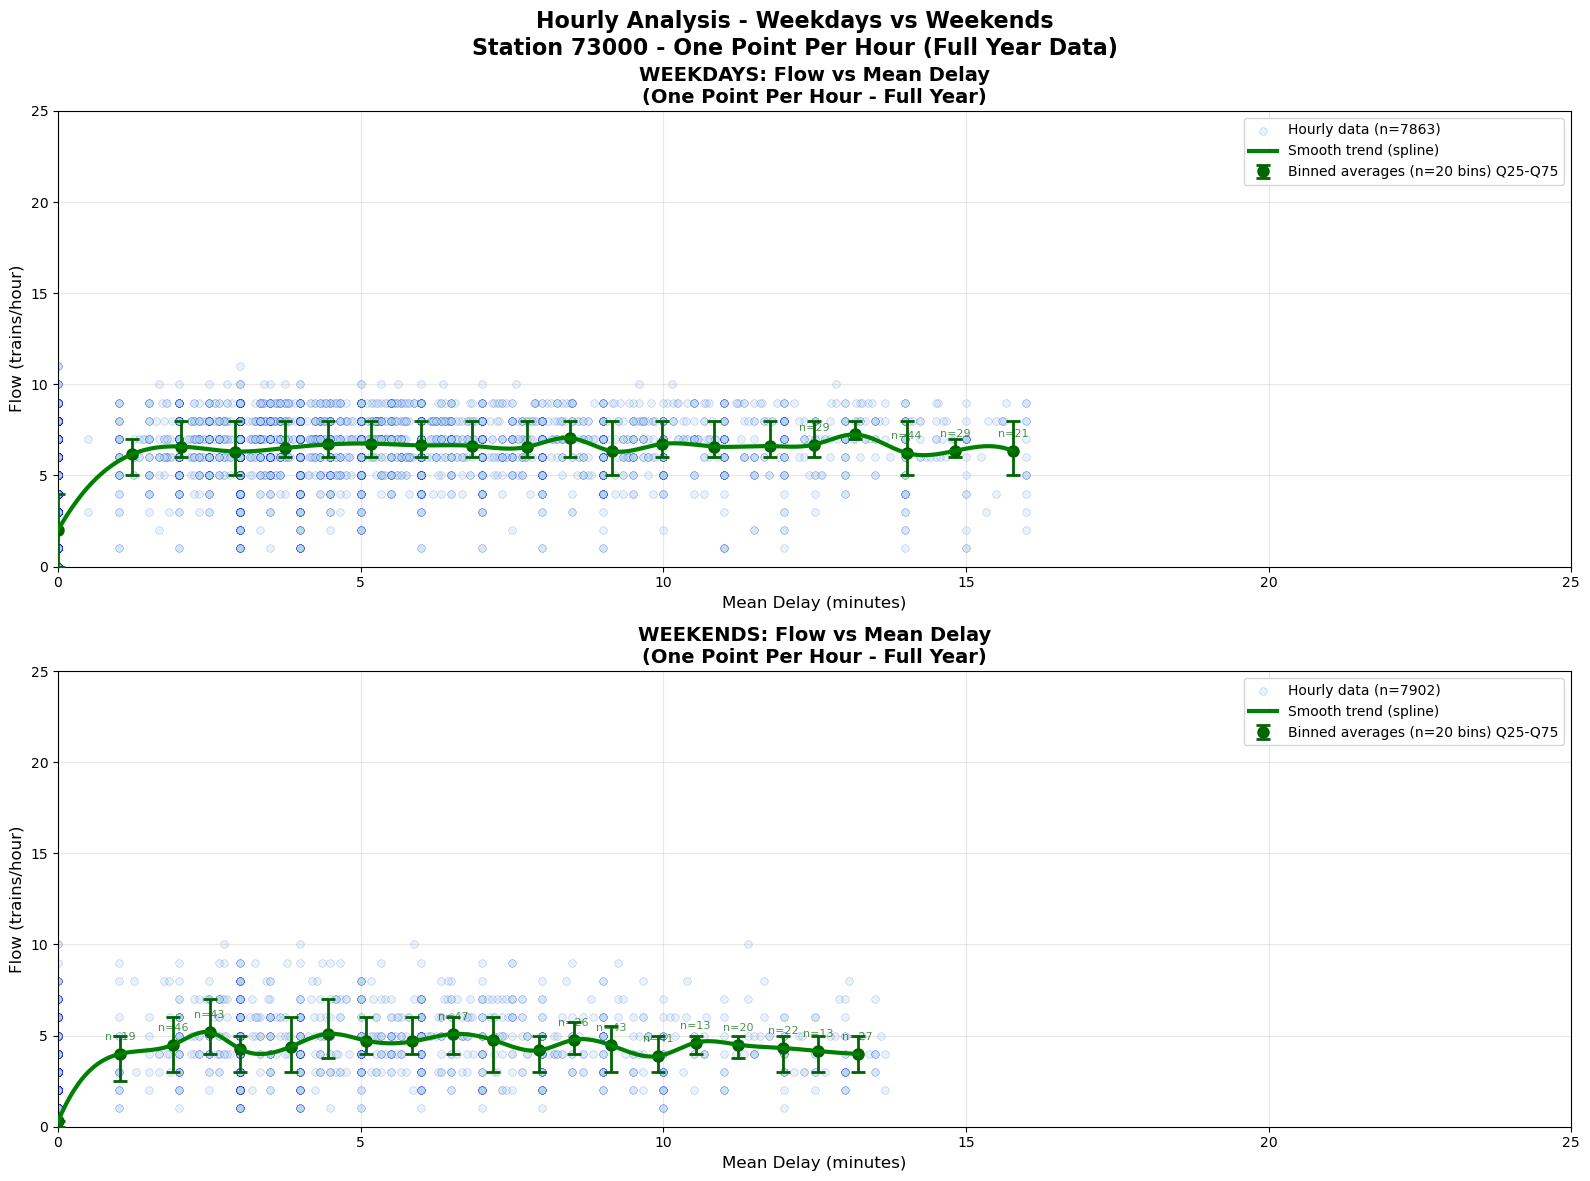

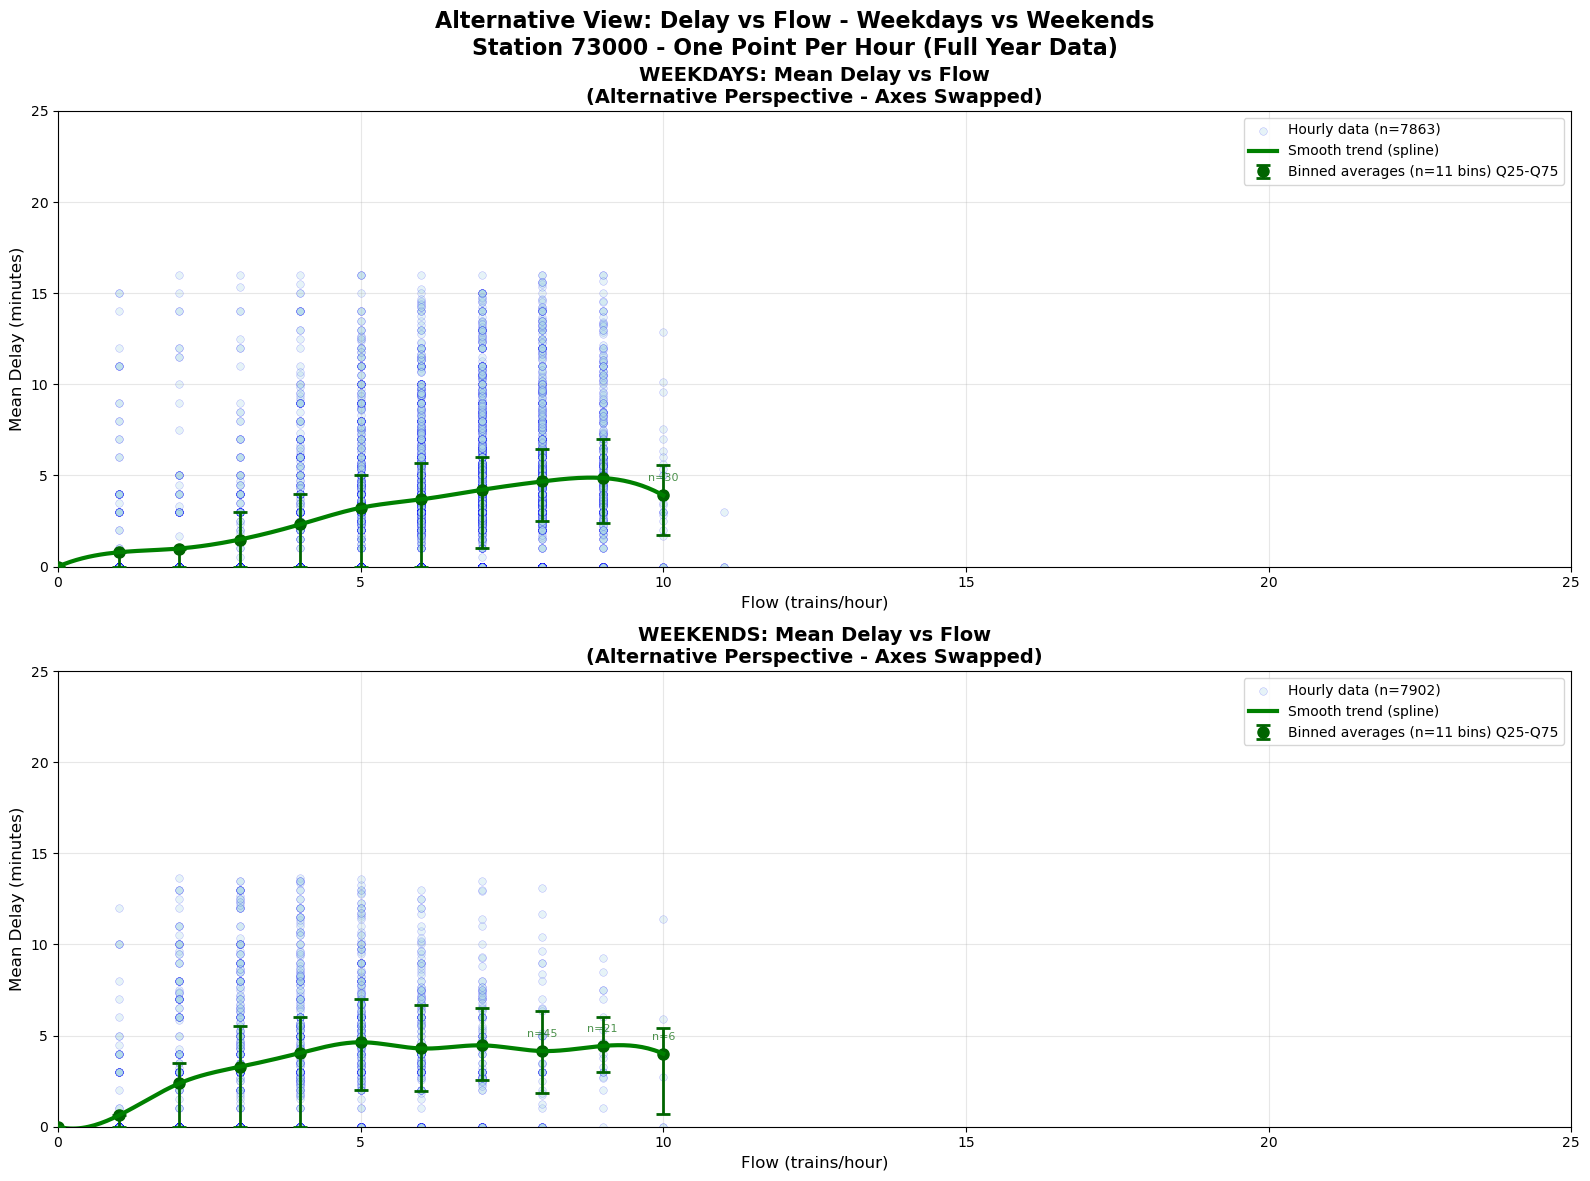

In [134]:
# Test the variable relationships function
print("Testing variable relationships function...")
relationships_results = plot_variable_relationships(
    station_id='73000',
    time_window_minutes=60,
    num_platforms=11,
    figsize=(16, 12),
    max_delay_percentile=98
)
plt.show()

Testing variable relationships function...
🚀 CREATING TEMPORAL FLOW ANALYSIS FOR STATION 32000
Loaded 217738 total records for station 32000
Using 214264 arrived trains (both incident and non-incident) for flow calculation
Creating datetime timestamps from EVENT_DATETIME...
Found date mappings for 7 day codes
  MO: 74 unique dates from 2024-02-05 to 2024-12-31
  TU: 72 unique dates from 2024-02-06 to 2025-01-01
  WE: 72 unique dates from 2024-02-07 to 2025-01-01
  TH: 73 unique dates from 2024-02-08 to 2025-01-03
  FR: 79 unique dates from 2024-02-09 to 2025-01-04
  SA: 66 unique dates from 2024-02-10 to 2025-01-04
  SU: 62 unique dates from 2024-02-04 to 2024-12-29
Found date mappings for 7 day codes
  MO: 74 unique dates from 2024-02-05 to 2024-12-31
  TU: 72 unique dates from 2024-02-06 to 2025-01-01
  WE: 72 unique dates from 2024-02-07 to 2025-01-01
  TH: 73 unique dates from 2024-02-08 to 2025-01-03
  FR: 79 unique dates from 2024-02-09 to 2025-01-04
  SA: 66 unique dates from 20

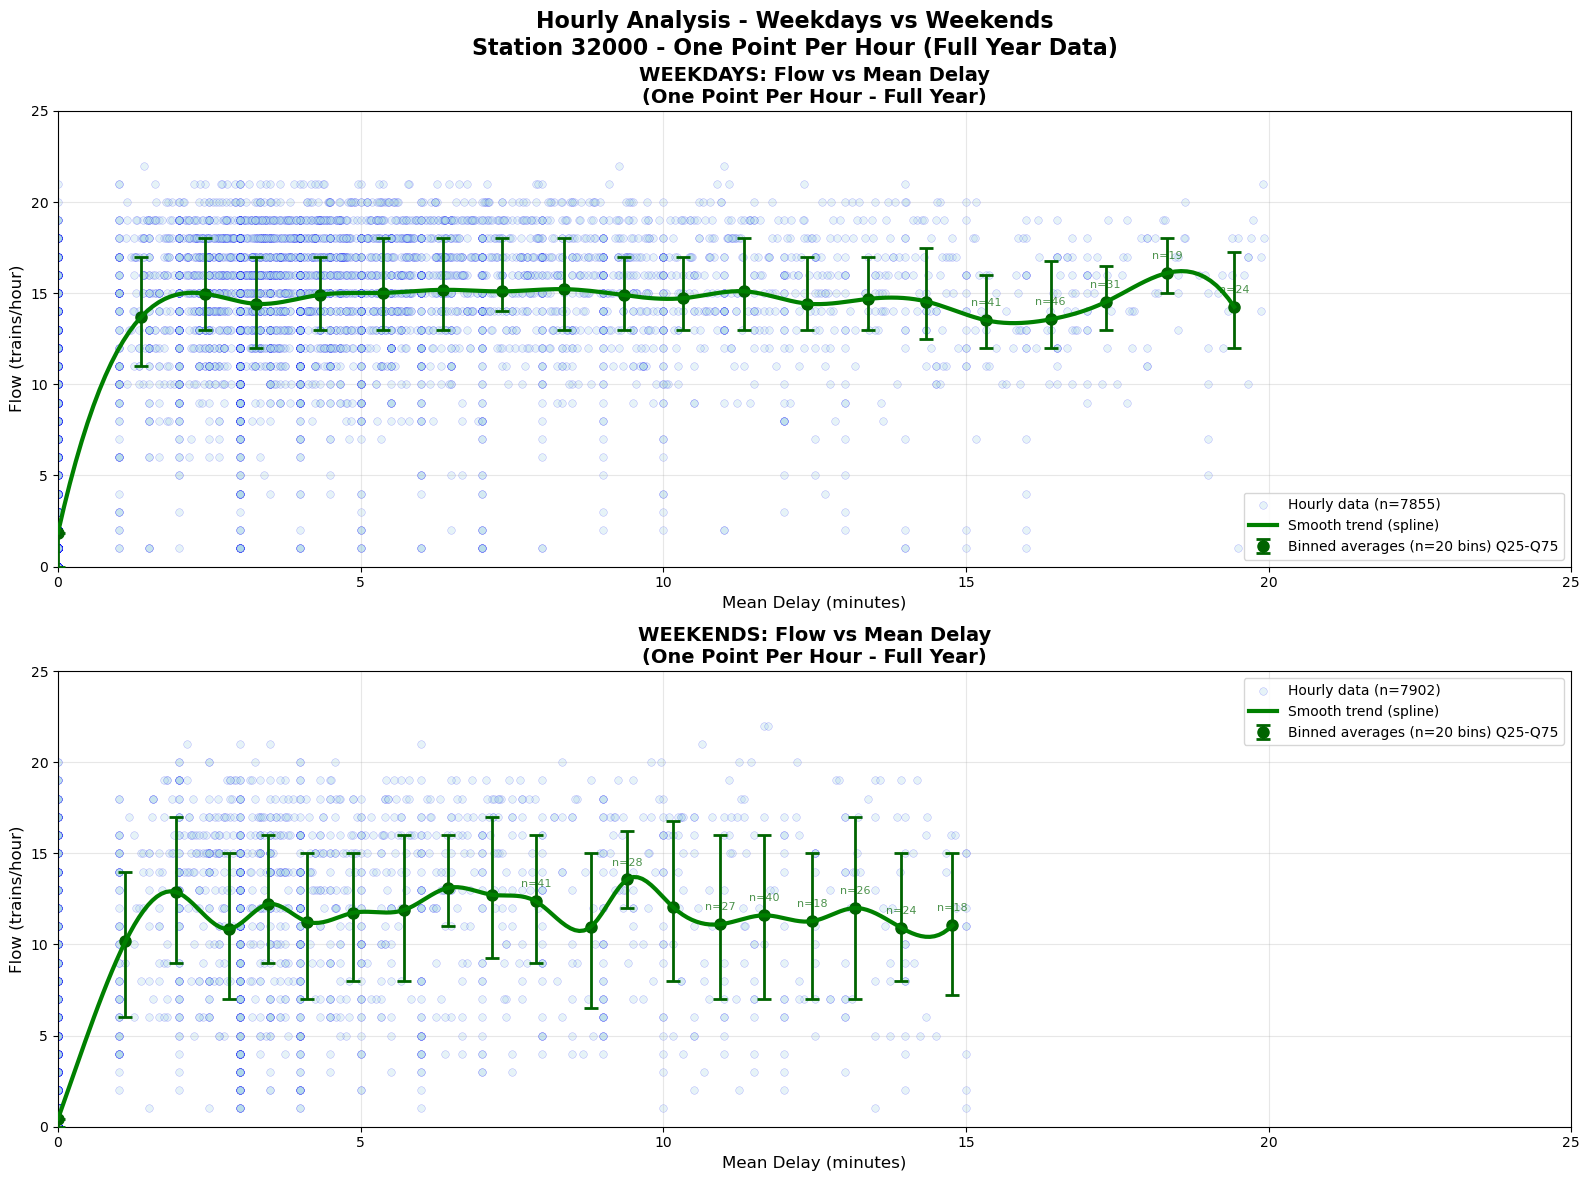

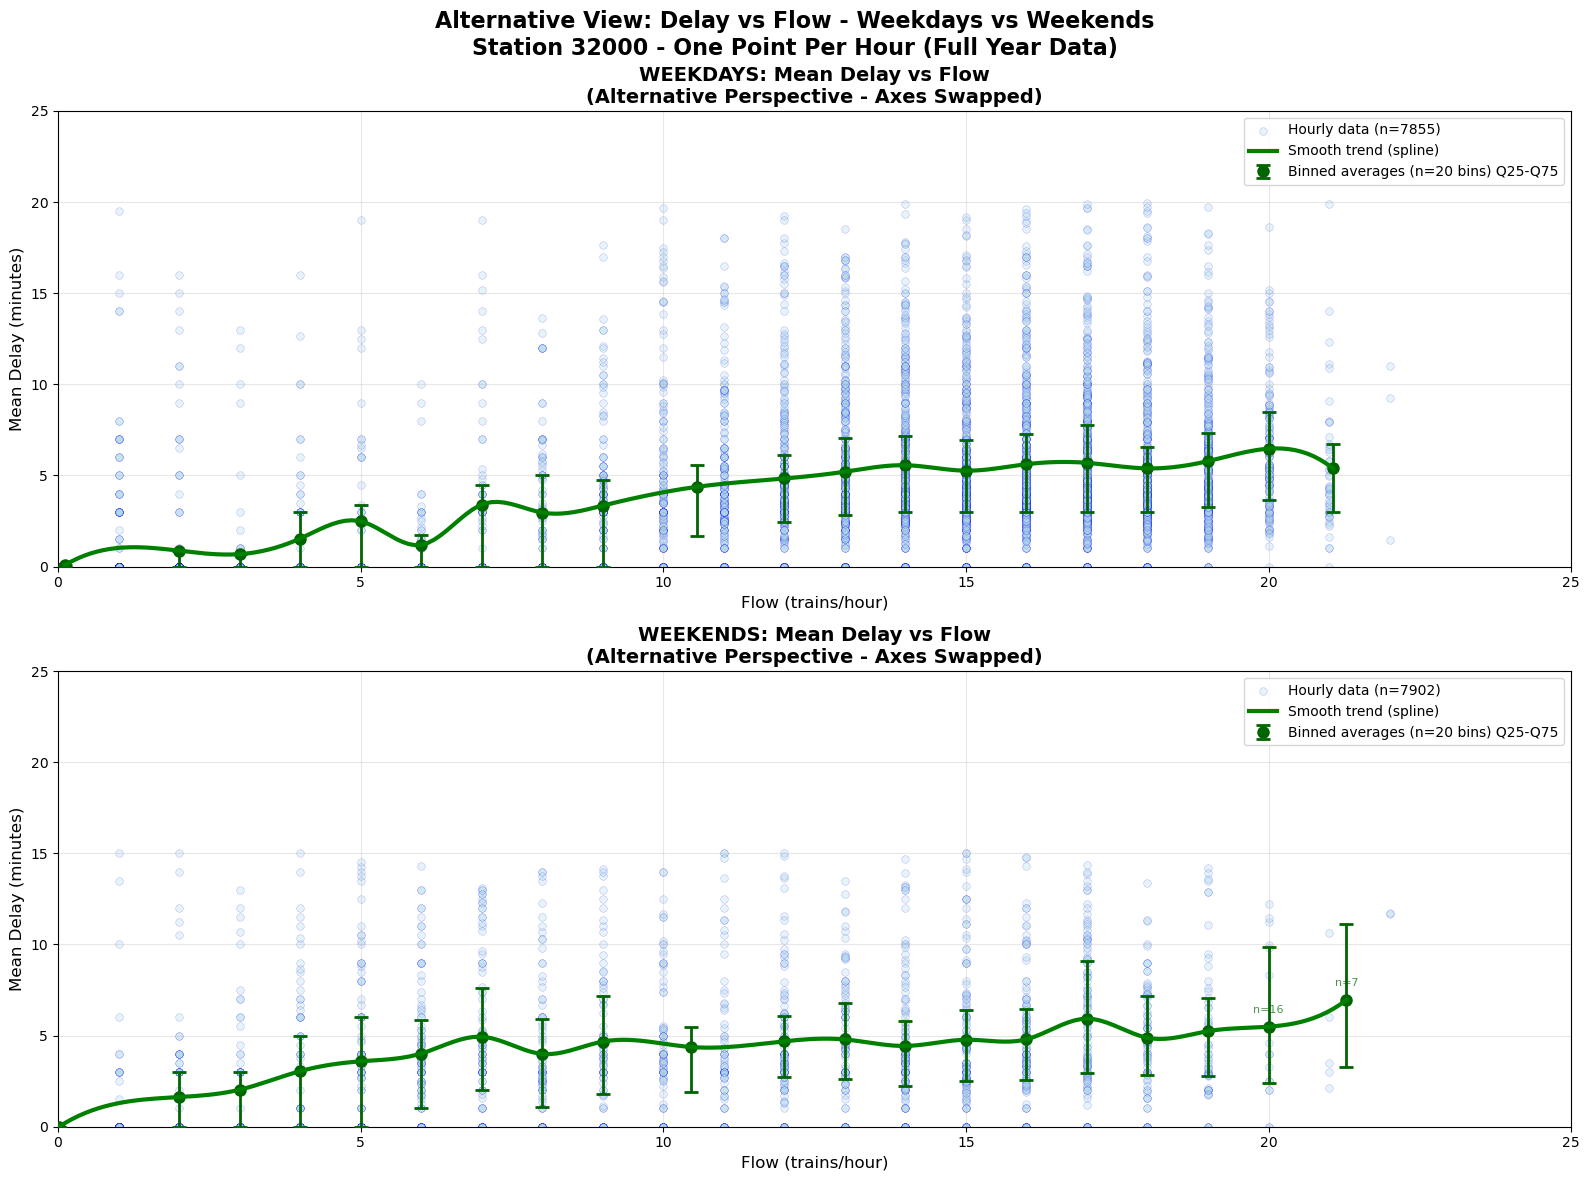

In [135]:
# Test the variable relationships function
print("Testing variable relationships function...")
relationships_results = plot_variable_relationships(
    station_id='32000',
    time_window_minutes=60,
    num_platforms=11,
    figsize=(16, 12),
    max_delay_percentile=98
)
plt.show()

🚀 CREATING TEMPORAL FLOW ANALYSIS FOR STATION 25701
Loaded 152879 total records for station 25701
Using 151018 arrived trains (both incident and non-incident) for flow calculation
Creating datetime timestamps from EVENT_DATETIME...
Found date mappings for 7 day codes
  MO: 80 unique dates from 2024-02-05 to 2024-12-31
  TU: 73 unique dates from 2024-02-06 to 2024-12-31
  WE: 81 unique dates from 2024-02-07 to 2025-01-02
  TH: 79 unique dates from 2024-02-08 to 2025-01-03
  FR: 75 unique dates from 2024-02-09 to 2025-01-03
  SA: 77 unique dates from 2024-02-10 to 2025-01-05
  SU: 60 unique dates from 2024-02-04 to 2024-12-29
Found date mappings for 7 day codes
  MO: 80 unique dates from 2024-02-05 to 2024-12-31
  TU: 73 unique dates from 2024-02-06 to 2024-12-31
  WE: 81 unique dates from 2024-02-07 to 2025-01-02
  TH: 79 unique dates from 2024-02-08 to 2025-01-03
  FR: 75 unique dates from 2024-02-09 to 2025-01-03
  SA: 77 unique dates from 2024-02-10 to 2025-01-05
  SU: 60 unique date

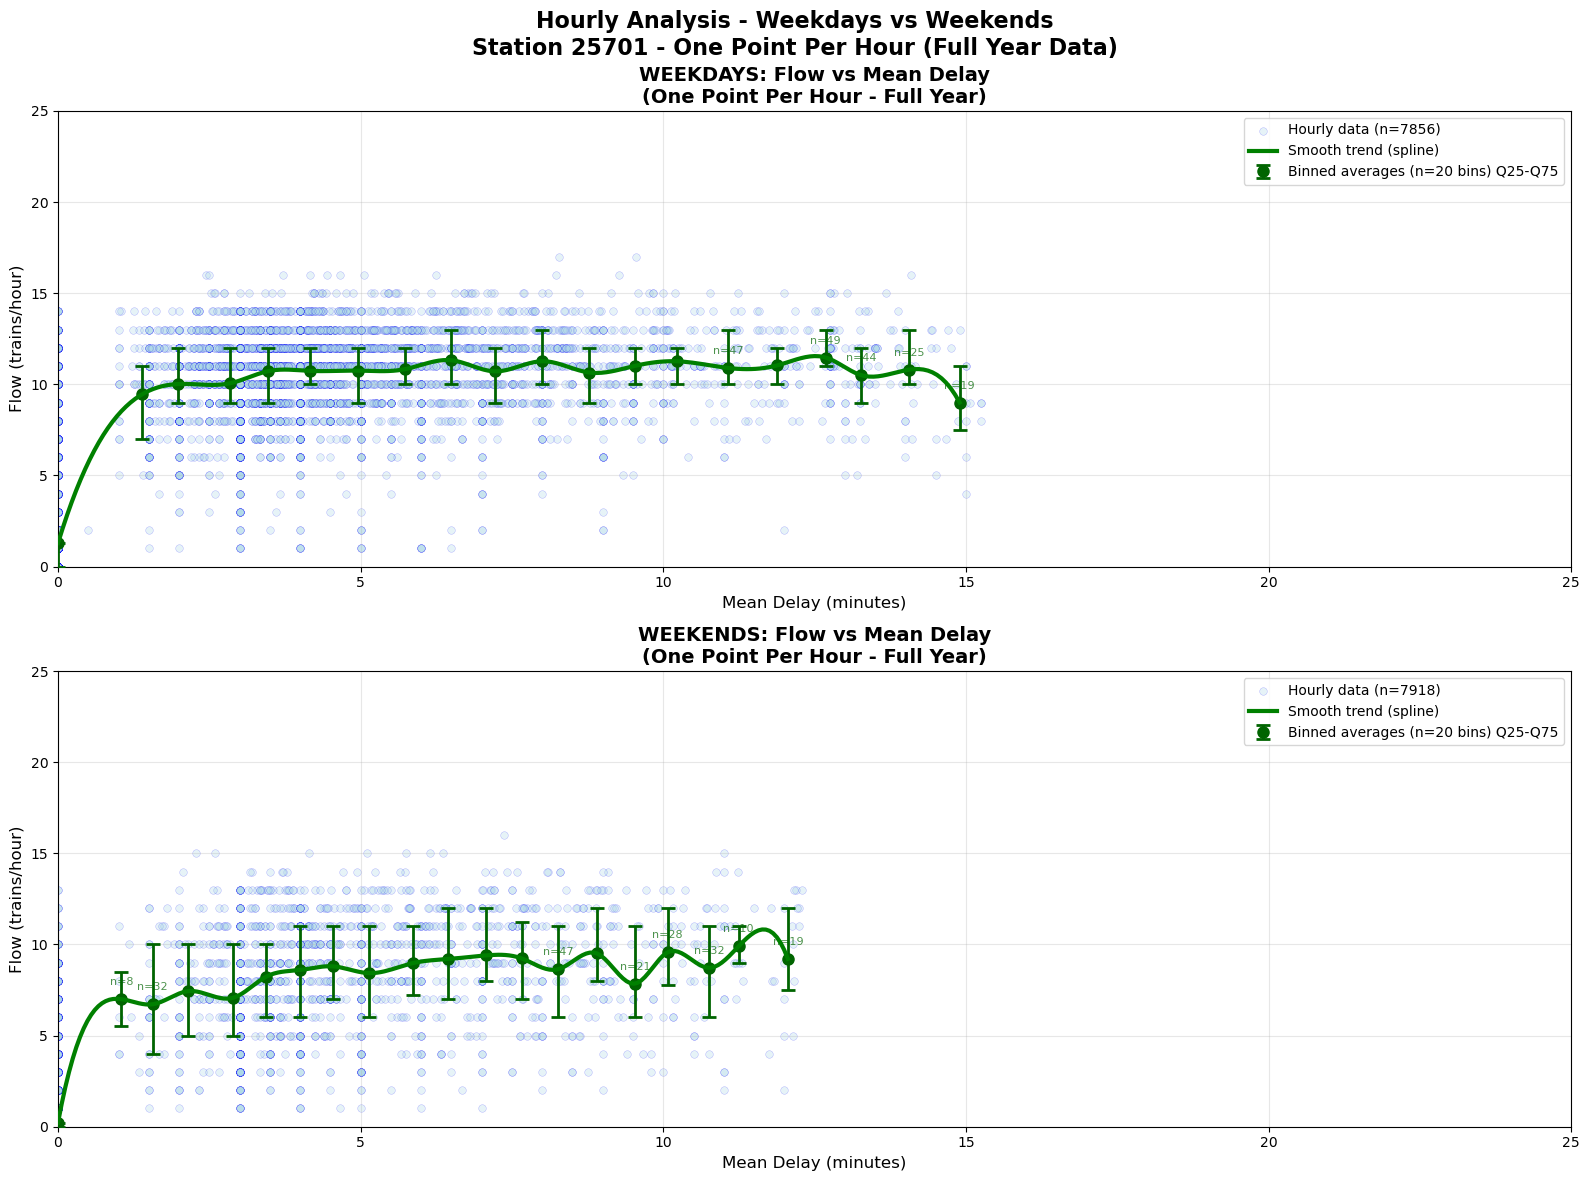

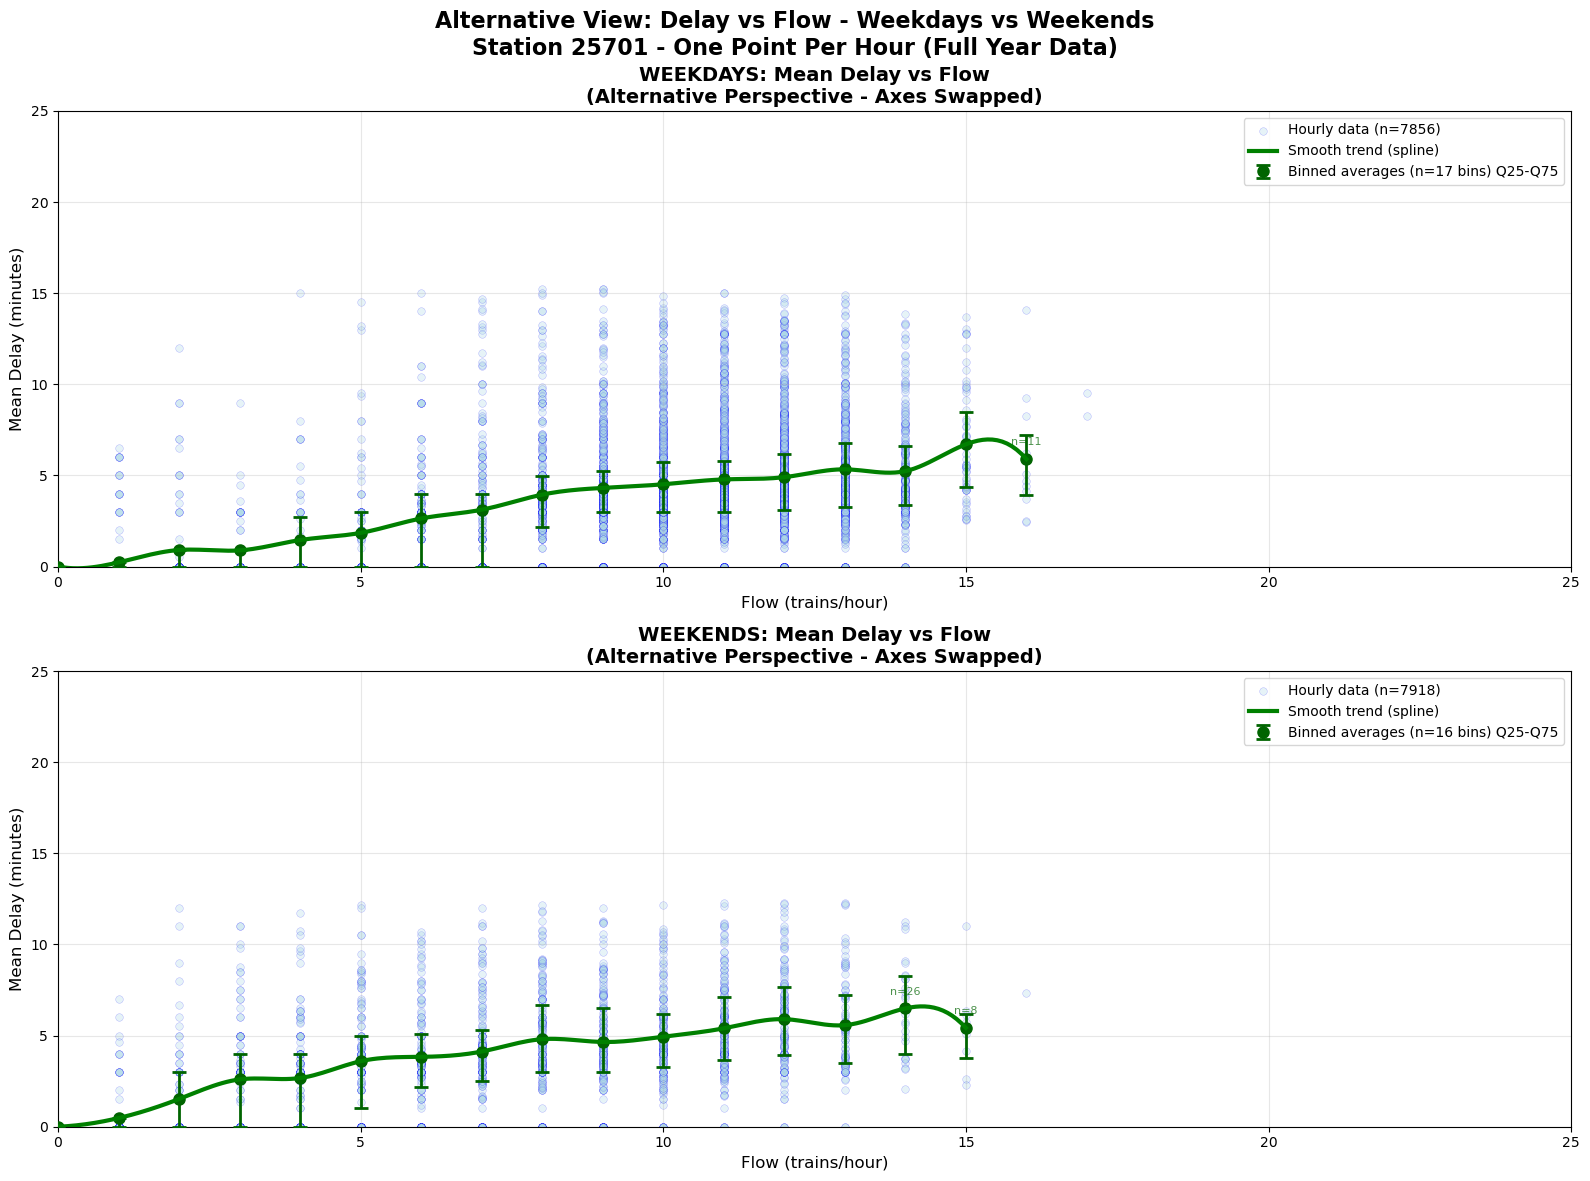

In [136]:
# Test for Brighton station_id = 87980
# Test for Sheffield station_id = 25701
relationships_results = plot_variable_relationships(
    station_id='25701',
    time_window_minutes=60,
    num_platforms=11,
    figsize=(16, 12),
    max_delay_percentile=98
)
plt.show()